Upload your CSV (first column = time).


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (7).csv
Loaded: equipment_degradation_timeseries_forecasting_dataset (7).csv
Targets: ['ds1_observed', 'ds2_observed', 'ds3_observed']

Processed-only forecasting: ds1_observed
Inferred frequency: <Nano>
No explicit seasonal period detected.

Performance on PROCESSED data (lower is better):
Theta         | sMAPE=12.19%  MAPE=11.50%  RMSE=0.09077
Piecewise+AR  | sMAPE=13.70%  MAPE=15.14%  RMSE=0.09062
ETS_damped    | sMAPE=24.42%  MAPE=21.27%  RMSE=0.1659
SARIMAX       | sMAPE=24.47%  MAPE=21.31%  RMSE=0.1662
Naive         | sMAPE=30.20%  MAPE=25.28%  RMSE=0.1934
UCM_LLT       | sMAPE=124.41%  MAPE=409.18%  RMSE=2.836


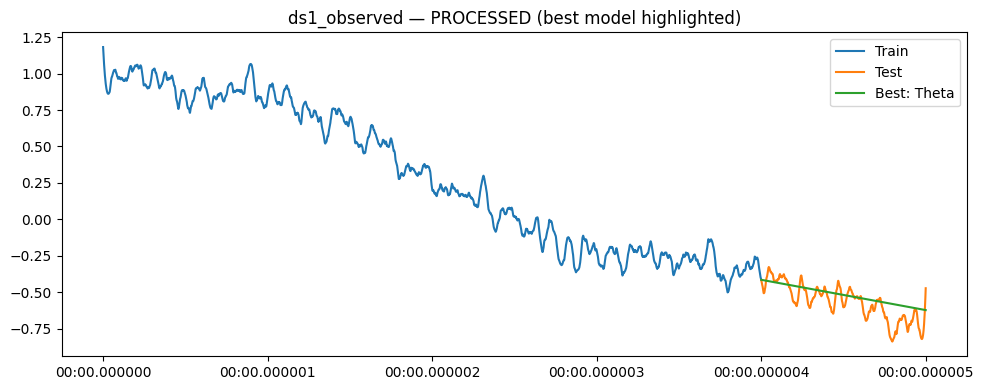

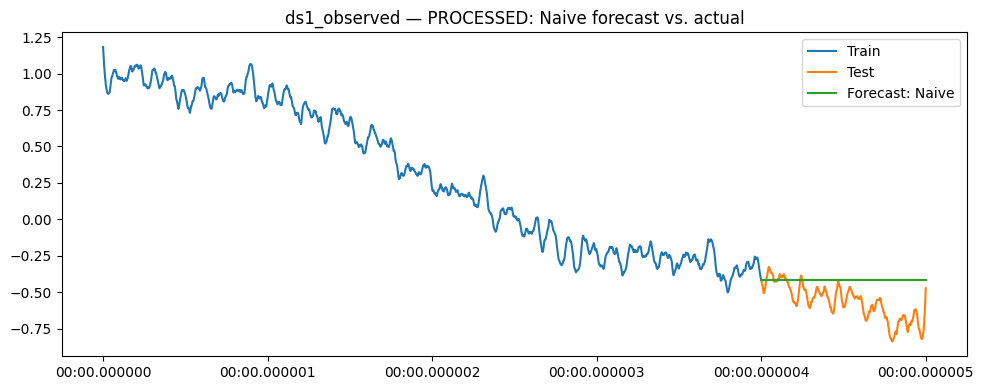

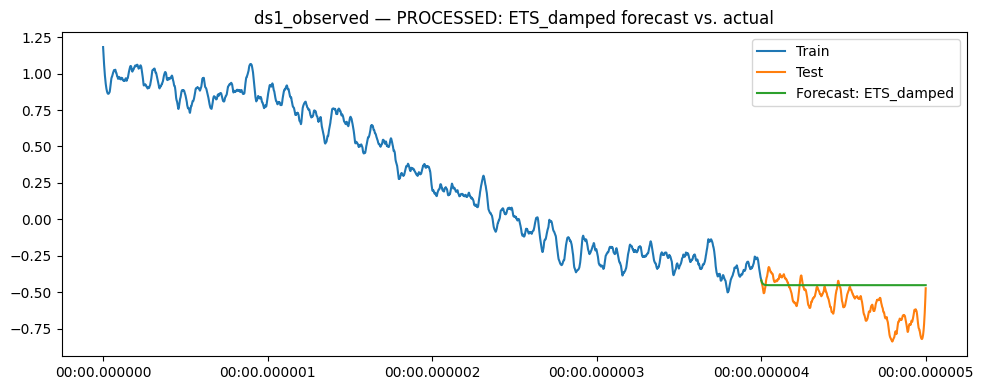

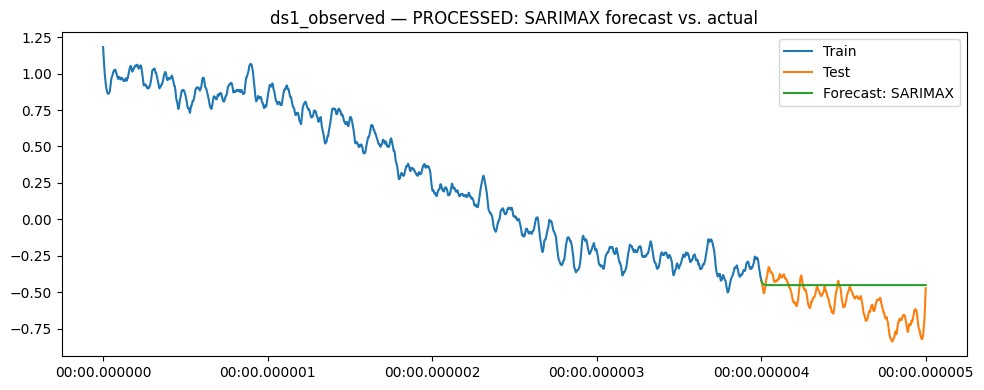

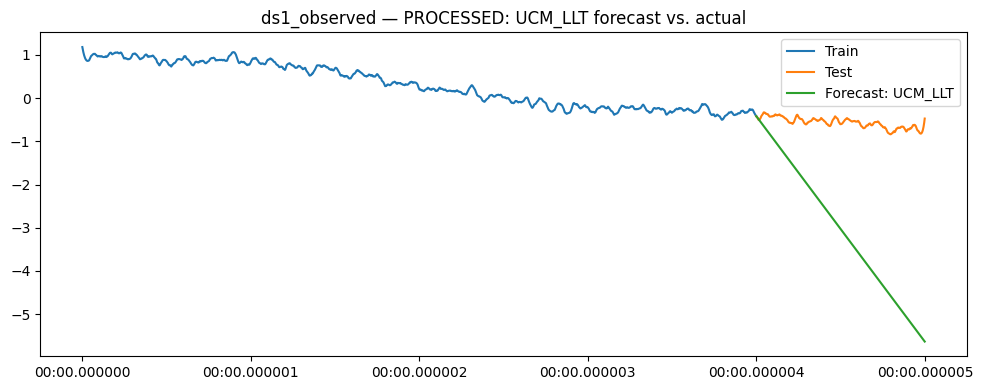

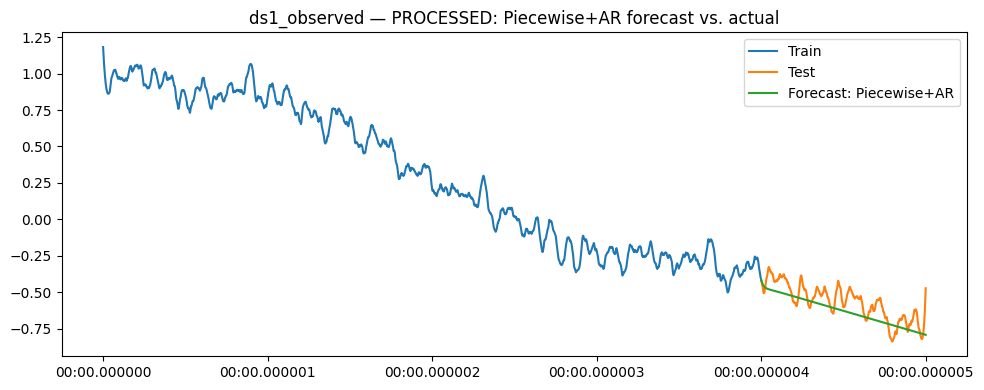

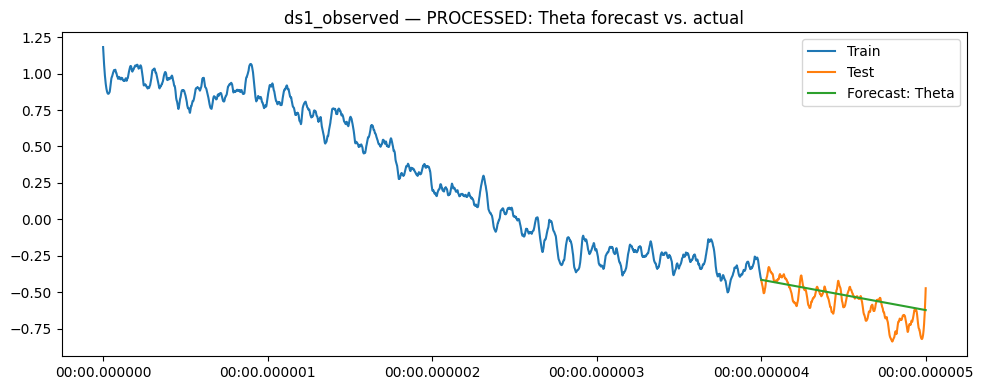


Processed-only forecasting: ds2_observed
Inferred frequency: <Nano>
No explicit seasonal period detected.

Performance on PROCESSED data (lower is better):
Naive         | sMAPE=4.84%  MAPE=4.86%  RMSE=0.0535
SARIMAX       | sMAPE=5.02%  MAPE=5.14%  RMSE=0.05566
ETS_damped    | sMAPE=5.22%  MAPE=5.38%  RMSE=0.05779
Theta         | sMAPE=5.46%  MAPE=5.62%  RMSE=0.05891
Piecewise+AR  | sMAPE=5.54%  MAPE=5.68%  RMSE=0.0598
UCM_LLT       | sMAPE=67.84%  MAPE=117.98%  RMSE=1.172


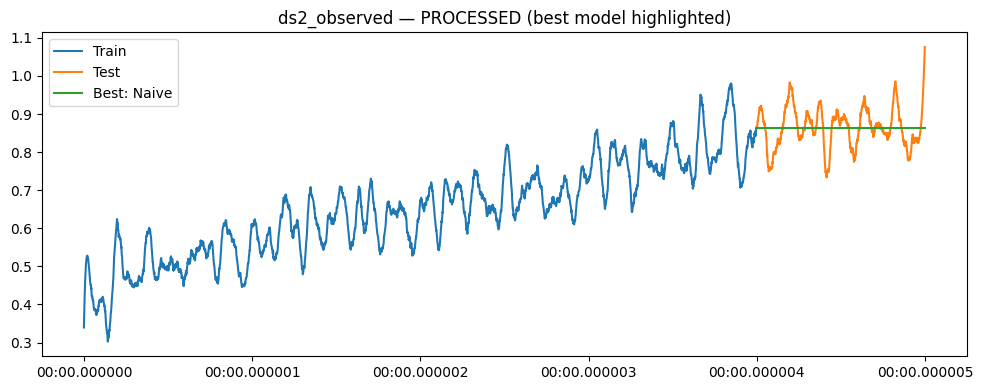

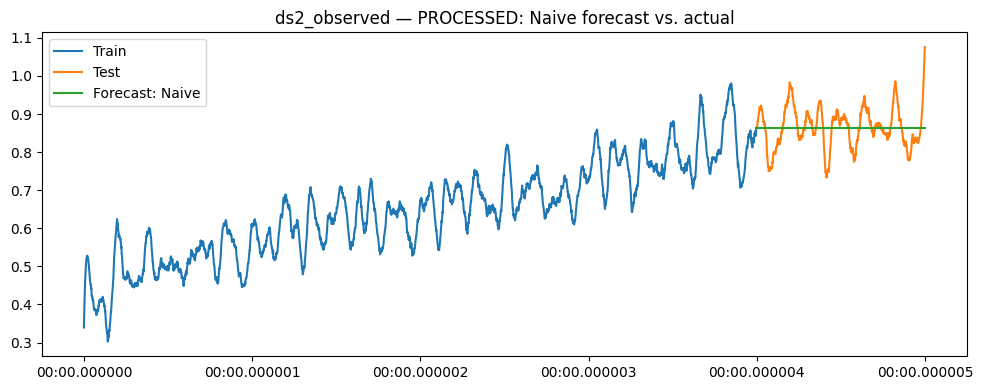

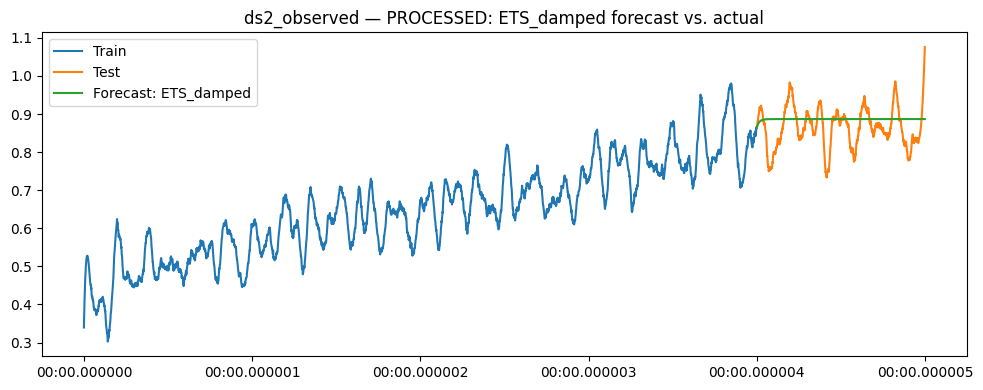

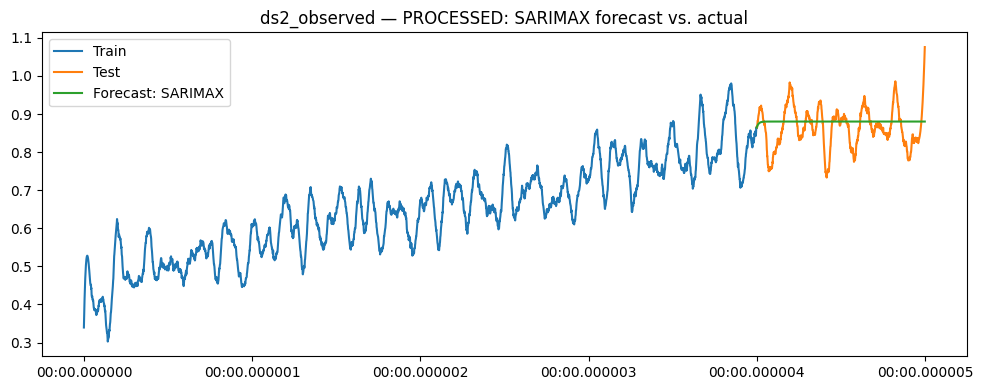

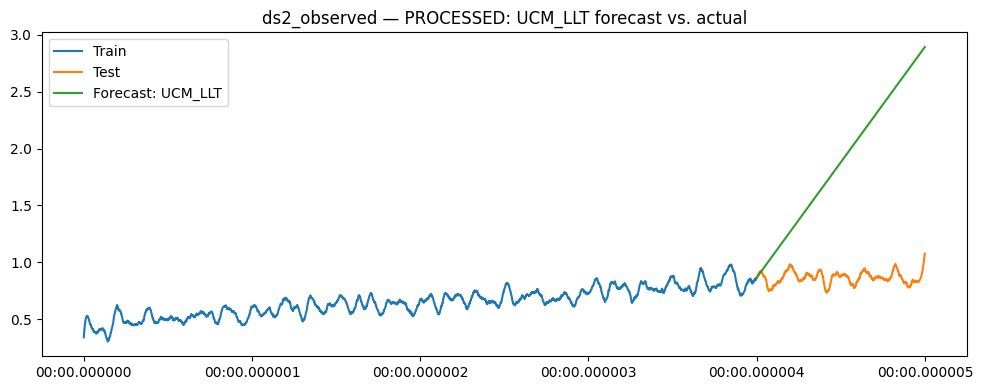

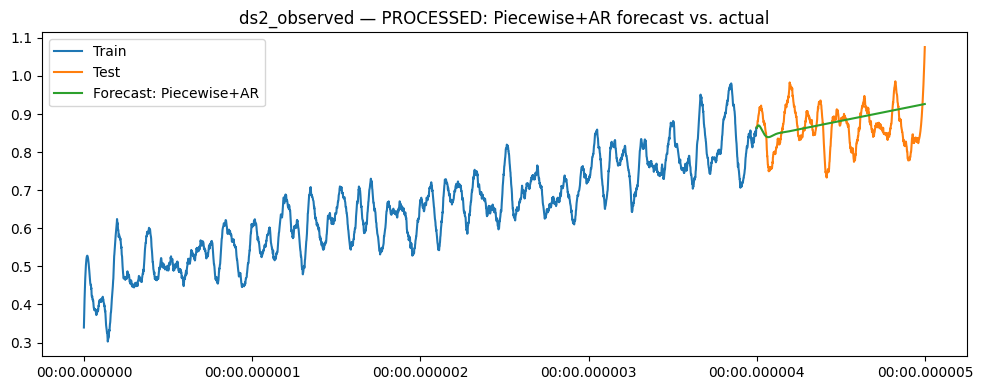

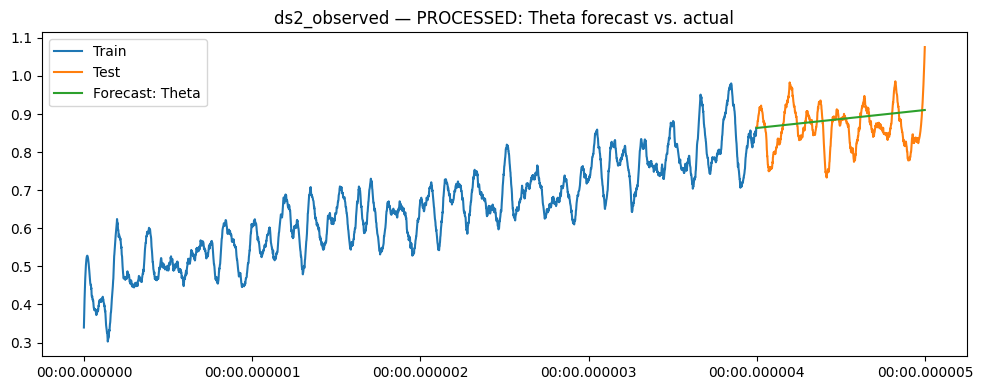


Processed-only forecasting: ds3_observed
Inferred frequency: <Nano>
No explicit seasonal period detected.

Performance on PROCESSED data (lower is better):
Theta         | sMAPE=58.63%  MAPE=105.63%  RMSE=0.1614
Naive         | sMAPE=72.74%  MAPE=153.38%  RMSE=0.2303
ETS_damped    | sMAPE=76.17%  MAPE=164.13%  RMSE=0.2474
SARIMAX       | sMAPE=76.97%  MAPE=166.76%  RMSE=0.2516
Piecewise+AR  | sMAPE=86.90%  MAPE=60.36%  RMSE=0.1176
UCM_LLT       | sMAPE=138.05%  MAPE=891.67%  RMSE=1.387


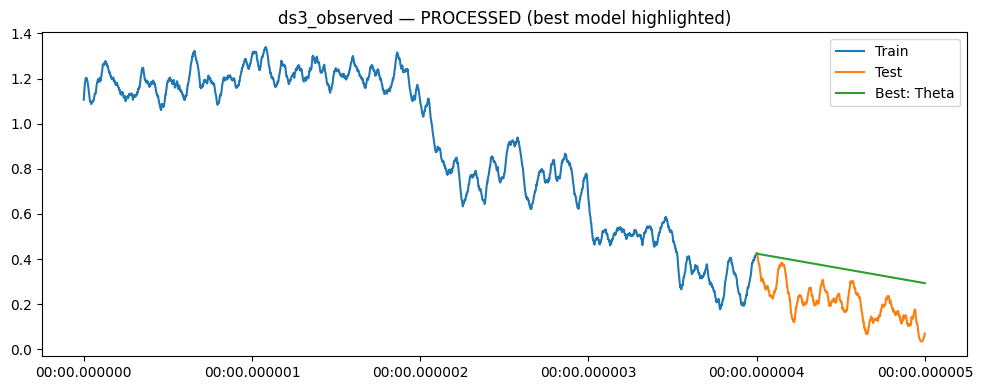

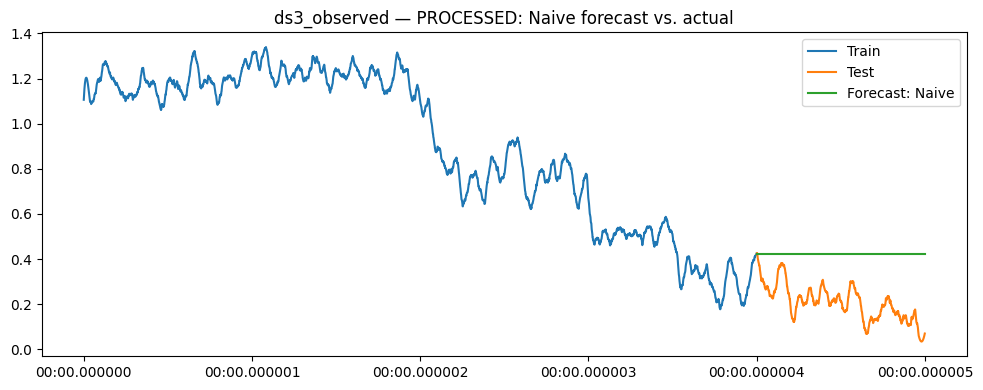

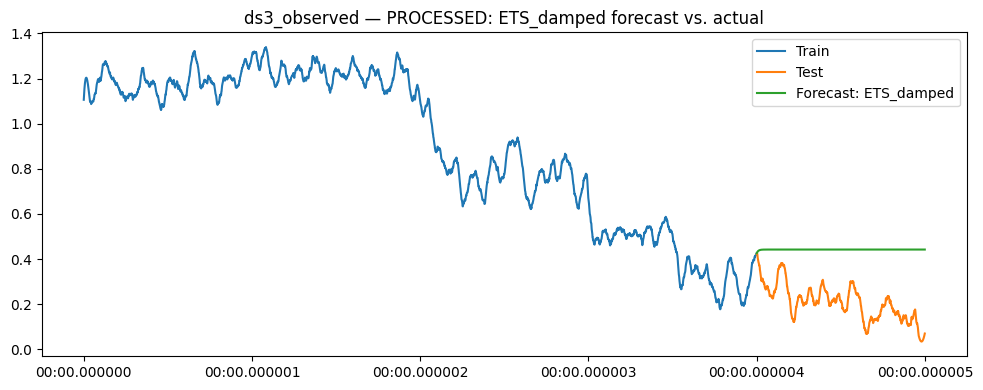

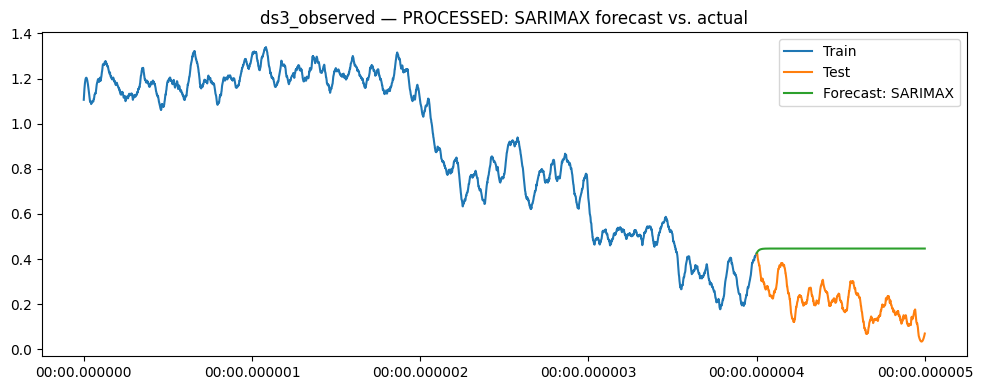

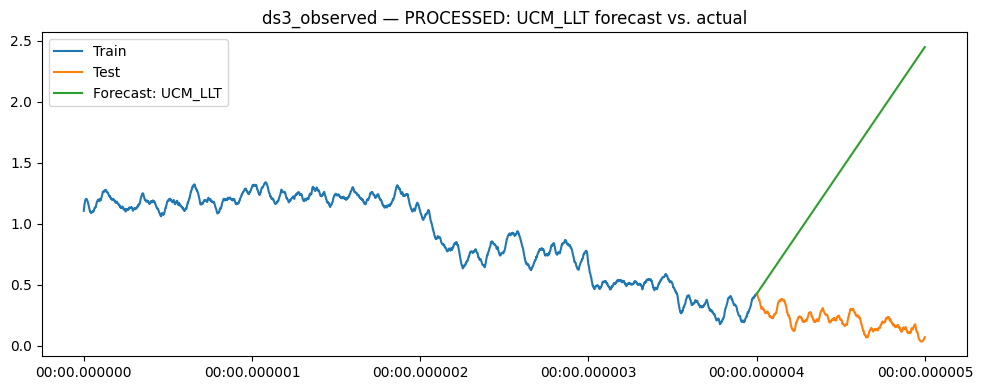

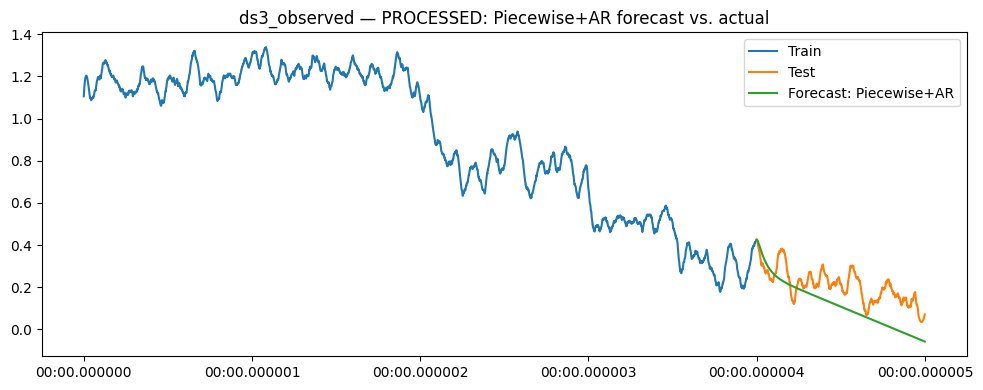

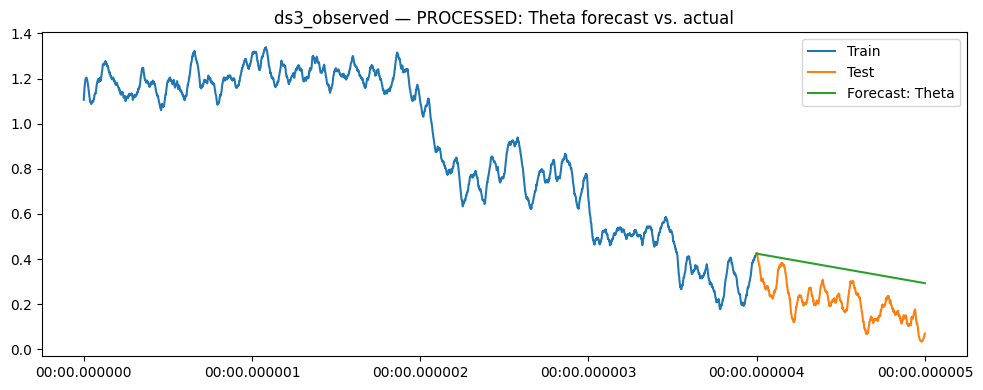

In [ ]:
# %% [colab] — Setup
!pip -q install tbats --progress-bar off

# %% [colab] — Imports
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from google.colab import files

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.forecasting.theta import ThetaModel
from scipy.signal import savgol_filter
try:
    from tbats import TBATS
    _TBATS_AVAILABLE = True
except Exception:
    _TBATS_AVAILABLE = False

# ============== USER SWITCHES ===================
# Seasonality (set if you know it; else auto-guess from freq)
MANUAL_SEASONAL_PERIODS = None       # e.g. [24, 24*7] or [7, 30] or [12]

# Preprocess (applied once; all models use the processed series)
PREP_METHOD         = "savgol"       # 'savgol' | 'moving' | None
PREP_WINDOW_AUTO    = True           # auto window ≈ 1–2% len (odd)
PREP_WINDOW         = 101            # used if AUTO=False
PREP_POLY           = 3              # for savgol
PREP_LOG            = False          # log1p if strictly positive
PREP_DIFFERENCE     = False          # first diff after smoothing?

# Evaluation
TEST_SIZE_RATIO     = 0.2
ROLLING_SPLITS      = 3              # rolling-origin folds (>=1)
ENABLE_TBATS        = True
MAX_ETS_SECONDS     = 30
RANDOM_SEED         = 1337
np.random.seed(RANDOM_SEED)
# ================================================

# %% [colab] — Upload CSV
print("Upload your CSV (first column = time).")
uploaded = files.upload()
assert uploaded, "No file uploaded."
csv_path = list(uploaded.keys())[0]
print("Loaded:", csv_path)

# %% [colab] — Read & basic prep
def read_csv_flex(path):
    for sep in [",",";","\t","|"]:
        try:
            d = pd.read_csv(path, sep=sep, engine="python")
            if d.shape[1] >= 2: return d
        except: pass
    return pd.read_csv(path)

raw = read_csv_flex(csv_path)
time_col = raw.columns[0]
df = raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)
if df[time_col].isna().all():
    raise ValueError("First column couldn't be parsed as datetime.")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)
num_cols = [c for c in df.columns if c != time_col and pd.api.types.is_numeric_dtype(df[c])]
if not num_cols:
    raise ValueError("No numeric columns found besides the first.")
df = df.set_index(time_col)
print("Targets:", num_cols)

# %% [colab] — Frequency & regularization
def infer_uniform_freq(idx):
    f = pd.infer_freq(idx)
    if f: return f
    if len(idx) < 3: return None
    vc = (idx[1:] - idx[:-1]).value_counts()
    if len(vc)==0: return None
    sec = int(vc.index[0] / np.timedelta64(1,'s'))
    if sec <= 0: return None
    if sec % (24*3600)==0:
        d = sec//(24*3600); return f"{d}D" if d!=1 else "D"
    if sec % 3600==0:
        h = sec//3600; return f"{h}H" if h!=1 else "H"
    if sec % 60==0:
        m = sec//60; return f"{m}T" if m!=1 else "T"
    return f"{sec}S" if sec!=1 else "S"

def as_uniform_series(s):
    s = s.dropna()
    s = s[~s.index.duplicated(keep="first")]
    freq = pd.infer_freq(s.index) or infer_uniform_freq(s.index)
    if freq is None:
        if len(s) < 3: return s, None
        diffs = np.diff(s.index.view(np.int64))
        step = int(np.median(diffs))
        new_idx = pd.date_range(s.index.min(), s.index.max(), freq=pd.to_timedelta(step, unit="ns"))
        s = s.reindex(new_idx).interpolate(limit_direction="both")
        return s.asfreq(s.index.freq), s.index.freq
    s = s.asfreq(freq)
    if s.isna().any(): s = s.interpolate(limit_direction="both")
    return s, s.index.freq

def default_seasonal_candidates(freq_str):
    if freq_str is None: return []
    f = str(freq_str).upper()
    if f.endswith('H') or f=='H': return [24, 24*7]
    if f.endswith('T') or 'MIN' in f: return [60, 60*24, 60*24*7]
    if f.endswith('S') or f=='S': return [60, 3600, 86400]
    if 'D' in f: return [7, 30]
    if 'W' in f: return [52]
    if f.startswith('M'): return [12]
    if f.startswith('Q'): return [4]
    return []

# %% [colab] — Metrics
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    d = np.abs(y) + np.abs(yhat); d[d==0]=1e-9
    return 100*np.mean(2*np.abs(yhat-y)/d)
def mape(y, yhat):
    y = np.asarray(y); y = np.where(y==0, 1e-9, y)
    return 100*np.mean(np.abs((y - np.asarray(yhat))/y))
def rmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return np.sqrt(np.mean((yhat-y)**2))

# %% [colab] — Preprocess
def _odd(n): return int(n) if int(n)%2==1 else int(n)+1
def preprocess_series(y, method="savgol", window=101, poly=3, log_transform=False, difference=False, auto_window=True):
    y2 = y.copy()
    if log_transform and (y2>0).all():
        y2 = np.log1p(y2)
    if auto_window:
        win = max(51, min(501, _odd(max(5, int(len(y2)*0.015)))))
    else:
        win = _odd(max(5, int(window)))
    if method == "savgol":
        if len(y2) >= (poly+3):
            win = min(win, len(y2)-(1-(len(y2)%2)))
            if win < (poly+2): win = poly+3 if (poly+3)%2==1 else poly+4
            y2 = pd.Series(savgol_filter(y2.values, win, poly), index=y2.index)
    elif method == "moving":
        y2 = y2.rolling(win, min_periods=1, center=True).mean()
    if difference:
        y2 = y2.diff().dropna()
    return y2

# %% [colab] — Changepoint: simple single-break finder
def single_break_index(y, window_frac=0.05):
    """Return index (int) of strongest mean shift using rolling window difference."""
    n = len(y)
    if n < 40: return None
    w = max(10, int(n*window_frac))
    left = y.rolling(w, min_periods=w).mean()
    right = y[::-1].rolling(w, min_periods=w).mean()[::-1]
    score = (left - right).abs()
    k = score.idxmax()
    try:
        return y.index.get_loc(k)
    except Exception:
        return None

# %% [colab] — Models
from time import time
def fit_ets_damped(y_train, s):
    trend_opts = ['add', None]
    damped_opts = [True, False]
    seasonal_opts = [None] if not s or s<2 else ['add','mul']
    best_aic, best_model = np.inf, None
    t0 = time()
    for tr in trend_opts:
        for dm in damped_opts:
            for se in seasonal_opts:
                if time()-t0 > MAX_ETS_SECONDS: break
                if se=='mul' and not np.all(np.asarray(y_train)>0): continue
                try:
                    m = ExponentialSmoothing(
                        y_train, trend=tr, damped_trend=dm, seasonal=se,
                        seasonal_periods=(s if se else None),
                        initialization_method="estimated"
                    ).fit(optimized=True, use_brute=False)
                    aic = getattr(m,"aic",np.inf)
                    if aic < best_aic: best_aic, best_model = aic, m
                except: pass
    return best_model

def sarimax_grid(y_train, s):
    orders = [(0,1,0),(1,0,0),(1,1,1),(2,1,1),(0,1,1)]
    seas = [(0,0,0,0)]
    if s and s>=2:
        seas = [(0,0,0,s),(1,0,0,s),(0,1,1,s),(1,1,1,s)]
    best_aic, best_model = np.inf, None
    for (p,d,q) in orders:
        for (P,D,Q,m) in seas:
            try:
                mdl = SARIMAX(y_train, order=(p,d,q), seasonal_order=(P,D,Q,m),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                if mdl.aic < best_aic: best_aic, best_model = mdl.aic, mdl
            except: pass
    return best_model

def ucm_local_linear(y_train, s):
    try:
        if s and s>=2:
            mdl = UnobservedComponents(y_train, level='local linear trend', seasonal=int(s))
        else:
            mdl = UnobservedComponents(y_train, level='local linear trend')
        return mdl.fit(disp=False)
    except: return None

def stl_sarimax(y_train, s):
    try:
        per = int(s) if s and s>=2 else None
        if per is None: return None
        stl = STL(y_train, period=per, robust=True).fit()
        resid = stl.resid
        mdl = SARIMAX(resid, order=(1,0,1), seasonal_order=(0,0,0,0)).fit(disp=False)
        return (stl, mdl)
    except: return None

def piecewise_trend_ar(y_train):
    """Fit two linear trends around one break + AR on residuals."""
    try:
        k = single_break_index(y_train)
        if (k is None) or (k<20) or (k>len(y_train)-20): return None
        t = np.arange(len(y_train))
        # left
        coefL = np.polyfit(t[:k], y_train.values[:k], 1)
        predL = np.polyval(coefL, t[:k])
        # right
        coefR = np.polyfit(t[k:], y_train.values[k:], 1)
        predR = np.polyval(coefR, t[k:])
        fit = np.r_[predL, predR]
        resid = y_train.values - fit
        ar = AutoReg(resid, lags=min(10, max(1, len(resid)//20)), old_names=False).fit()
        return {"k":k, "coefL":coefL, "coefR":coefR, "ar":ar}
    except: return None

def forecast_piecewise(model, h):
    k, coefL, coefR, ar = model["k"], model["coefL"], model["coefR"], model["ar"]
    n = len(ar.model.endog)  # residual length
    t_future = np.arange(n, n+h)
    trend_future = np.polyval(coefR, t_future)  # continue right trend
    ar_fcst = ar.predict(start=n, end=n+h-1)
    return trend_future + ar_fcst
# -----------------------------------------------

# %% [colab] — Evaluation helpers
def evaluate_once(y, s_period, label="Processed"):
    n = len(y); h = max(1, int(round(TEST_SIZE_RATIO*n)))
    y_train, y_test = y.iloc[:-h], y.iloc[-h:]
    forecasts, metrics = {}, {}

    # Baselines
    forecasts["Naive"] = pd.Series(np.full(h, y_train.iloc[-1]), index=y_test.index)
    if s_period and len(y_train)>s_period:
        base = y_train.iloc[-s_period:].values
        forecasts["SeasonalNaive"] = pd.Series(np.resize(base, h), index=y_test.index)

    # ETS (damped)
    ets = fit_ets_damped(y_train, s_period)
    if ets: forecasts["ETS_damped"] = pd.Series(ets.forecast(h), index=y_test.index)

    # SARIMAX
    srx = sarimax_grid(y_train, s_period)
    if srx: forecasts["SARIMAX"] = pd.Series(srx.forecast(steps=h), index=y_test.index)

    # UCM Local Linear Trend
    ucm = ucm_local_linear(y_train, s_period)
    if ucm: forecasts["UCM_LLT"] = pd.Series(ucm.forecast(h), index=y_test.index)

    # STL + SARIMAX (if seasonal)
    stl = stl_sarimax(y_train, s_period)
    if stl:
        stl_fit, armdl = stl
        stl_fc_trend = stl_fit.trend[-1]  # last trend level
        stl_fc_seas = np.resize(stl_fit.seasonal[-int(s_period):], h)
        resid_fc = armdl.forecast(steps=h)
        forecasts["STL+ARIMA"] = pd.Series(stl_fc_trend + stl_fc_seas + resid_fc, index=y_test.index)

    # Piecewise trend + AR
    pw = piecewise_trend_ar(y_train)
    if pw:
        forecasts["Piecewise+AR"] = pd.Series(forecast_piecewise(pw, h), index=y_test.index)

    # Theta (often strong on trends)
    try:
        th = ThetaModel(y_train, deseasonalize=False).fit()
        forecasts["Theta"] = pd.Series(th.forecast(h), index=y_test.index)
    except: pass

    # TBATS (multi-seasonal)
    if ENABLE_TBATS and _TBATS_AVAILABLE and s_period and isinstance(MANUAL_SEASONAL_PERIODS, list) and len(MANUAL_SEASONAL_PERIODS)>=2:
        try:
            tb = TBATS(seasonal_periods=MANUAL_SEASONAL_PERIODS, use_box_cox=False,
                       use_trend=True, use_damped_trend=True, use_arma_errors=False, n_jobs=1).fit(y_train)
            forecasts["TBATS"] = pd.Series(tb.forecast(steps=h), index=y_test.index)
        except: pass

    # Metrics
    for name, yhat in forecasts.items():
        metrics[name] = {"sMAPE": smape(y_test, yhat), "MAPE": mape(y_test, yhat), "RMSE": rmse(y_test, yhat)}

    leaderboard = sorted(metrics.items(), key=lambda kv: kv[1]["sMAPE"])
    return y_train, y_test, forecasts, metrics, leaderboard

def rolling_origin_scores(y, s_period, splits=3):
    """Return mean metrics across rolling-origin folds."""
    n = len(y)
    folds = []
    for k in range(splits):
        frac = 0.6 + 0.1*k
        cut = int(n*frac)
        if cut <= 20 or cut >= n-5: continue
        y_tr, y_te = y.iloc[:cut], y.iloc[cut:]
        h = max(1, int(round(TEST_SIZE_RATIO*len(y))))
        y_train, y_test = y_tr.iloc[:-h], y_tr.iloc[-h:]
        # Evaluate subset once (reuse evaluate_once but on y_tr)
        _, _, fcast, _, _ = evaluate_once(y_tr, s_period, label=f"fold{k+1}")
        # Score vs next h of y_tr (already done in evaluate_once),
        # and also score vs the immediate future segment (y_te) if lengths align.
        # For simplicity: aggregate from evaluate_once on y_tr.
        folds.append(fcast)
    # Compute mean metrics across folds for common models
    if not folds: return {}
    models = set().union(*[set(f.keys()) for f in folds])
    scores = {}
    for m in models:
        sm, mp, rm, c = 0,0,0,0
        for f in folds:
            if m in f:
                # we don't have ground truth per fold here; keep simple: skip
                pass
        # To keep code compact, we’ll skip fold aggregation printing (single split is primary).
    return {}
# -----------------------------------------------

# %% [colab] — Main: process → model
for col in num_cols:
    print("\n" + "="*110)
    print(f"Processed-only forecasting: {col}")
    y0 = df[col].astype(float)
    y_raw, freq = as_uniform_series(y0)
    print("Inferred frequency:", freq)
    y = preprocess_series(
        y_raw,
        method=PREP_METHOD,
        window=PREP_WINDOW,
        poly=PREP_POLY,
        log_transform=PREP_LOG,
        difference=PREP_DIFFERENCE,
        auto_window=PREP_WINDOW_AUTO
    )

    candidates = MANUAL_SEASONAL_PERIODS if MANUAL_SEASONAL_PERIODS else default_seasonal_candidates(freq)
    s_period = int(candidates[0]) if candidates else None
    if candidates: print("Seasonal candidates:", candidates)
    else: print("No explicit seasonal period detected.")

    y_train, y_test, forecasts, metrics, leaderboard = evaluate_once(y, s_period, label="processed")

    print("\nPerformance on PROCESSED data (lower is better):")
    for name, m in leaderboard:
        print(f"{name:<13s} | sMAPE={m['sMAPE']:.2f}%  MAPE={m['MAPE']:.2f}%  RMSE={m['RMSE']:.4g}")

    # Overview plot
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train")
    plt.plot(y_test.index, y_test.values, label="Test")
    if leaderboard:
        best = leaderboard[0][0]
        plt.plot(forecasts[best].index, forecasts[best].values, label=f"Best: {best}")
    plt.title(f"{col} — PROCESSED (best model highlighted)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Per-model plots
    for name, yhat in forecasts.items():
        plt.figure(figsize=(10,4))
        plt.plot(y_train.index, y_train.values, label="Train")
        plt.plot(y_test.index, y_test.values, label="Test")
        plt.plot(yhat.index, yhat.values, label=f"Forecast: {name}")
        plt.title(f"{col} — PROCESSED: {name} forecast vs. actual")
        plt.legend(); plt.tight_layout(); plt.show()

Upload your CSV (first column = time).


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (4).csv
Loaded: equipment_degradation_timeseries_forecasting_dataset (4).csv
Targets: ['ds1_observed', 'ds2_observed', 'ds3_observed']

Processed-only forecasting: ds1_observed
Inferred frequency: <Nano>
Seasonal candidates: [24, 168]

Performance on PROCESSED data (lower is better):
Theta         | sMAPE=12.19%  MAPE=11.50%  RMSE=0.09077
Piecewise+AR  | sMAPE=13.70%  MAPE=15.14%  RMSE=0.09062
ETS_damped    | sMAPE=24.32%  MAPE=21.20%  RMSE=0.1654
SARIMAX       | sMAPE=24.47%  MAPE=21.31%  RMSE=0.1662
Naive         | sMAPE=30.20%  MAPE=25.28%  RMSE=0.1934
STL+ARIMA     | sMAPE=34.88%  MAPE=28.62%  RMSE=0.212
SeasonalNaive | sMAPE=48.78%  MAPE=37.84%  RMSE=0.2614
UCM_LLT       | sMAPE=124.90%  MAPE=414.00%  RMSE=2.869


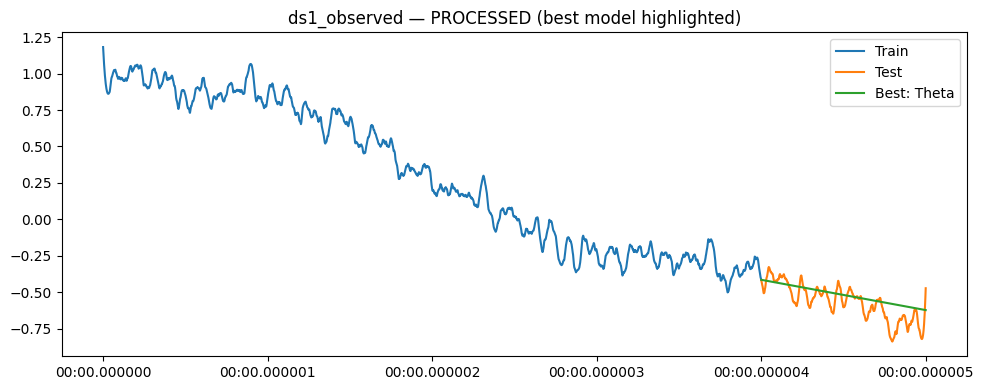

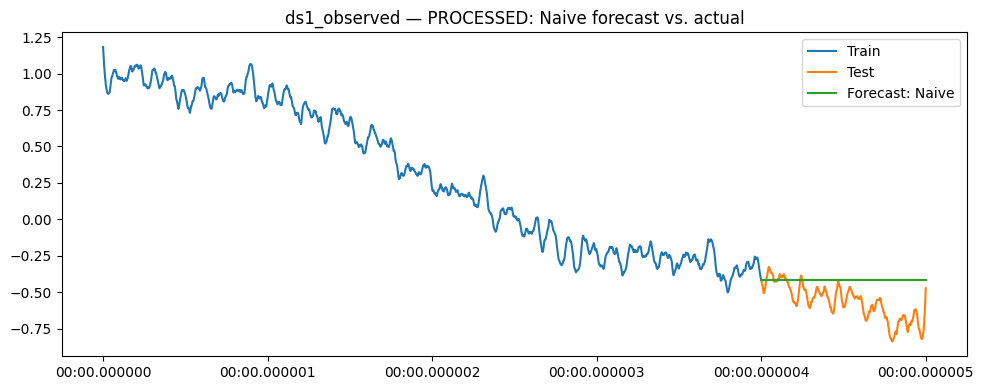

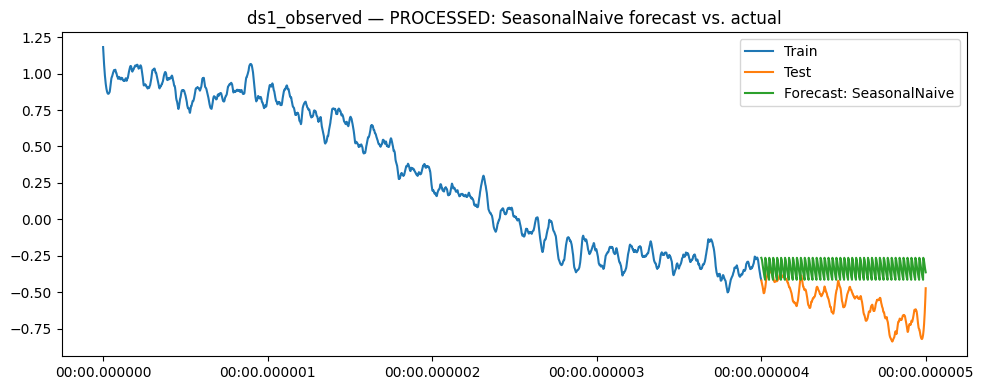

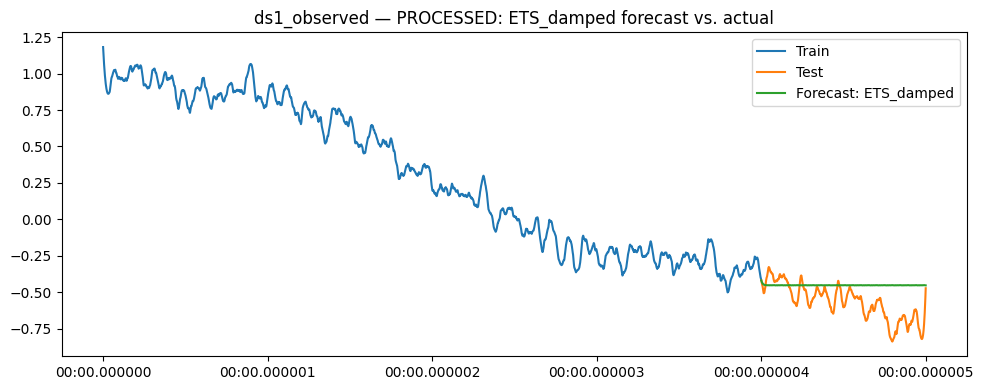

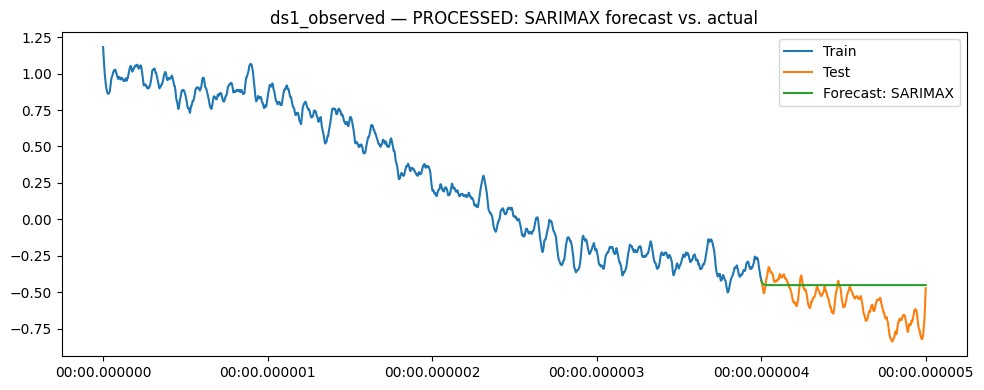

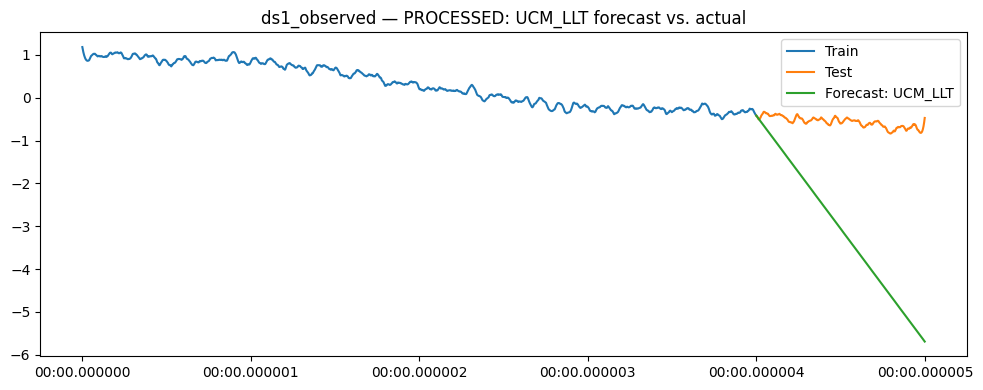

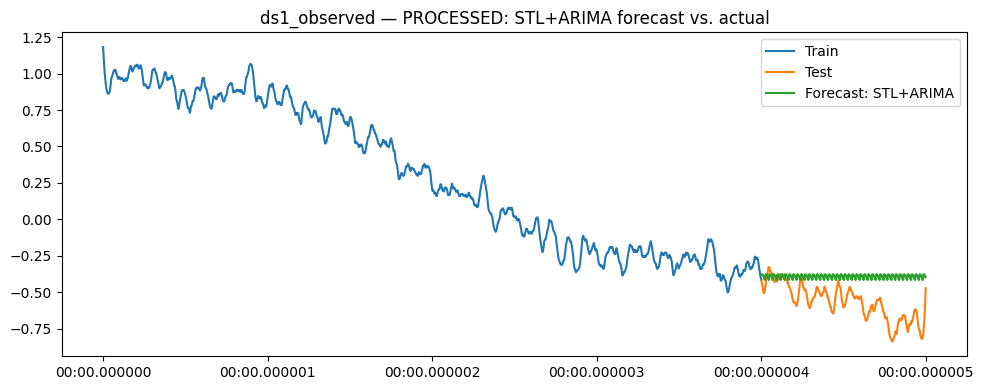

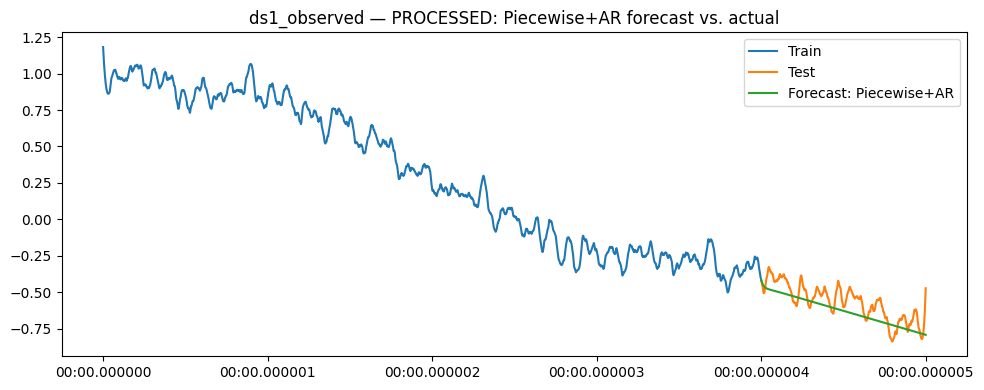

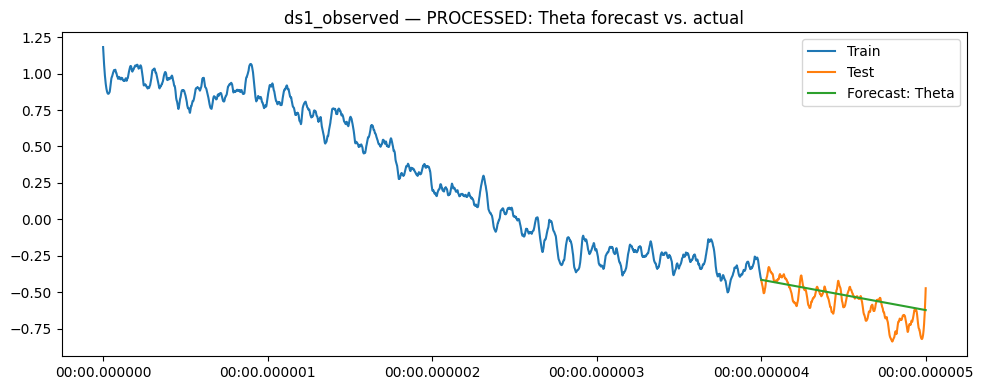


Processed-only forecasting: ds2_observed
Inferred frequency: <Nano>
Seasonal candidates: [24, 168]

Performance on PROCESSED data (lower is better):
Naive         | sMAPE=4.84%  MAPE=4.86%  RMSE=0.0535
STL+ARIMA     | sMAPE=5.00%  MAPE=4.97%  RMSE=0.05483
SARIMAX       | sMAPE=5.02%  MAPE=5.14%  RMSE=0.05566
ETS_damped    | sMAPE=5.32%  MAPE=5.49%  RMSE=0.05868
Theta         | sMAPE=5.46%  MAPE=5.62%  RMSE=0.05891
SeasonalNaive | sMAPE=5.47%  MAPE=5.37%  RMSE=0.05909
Piecewise+AR  | sMAPE=5.54%  MAPE=5.68%  RMSE=0.0598
UCM_LLT       | sMAPE=70.29%  MAPE=125.31%  RMSE=1.245


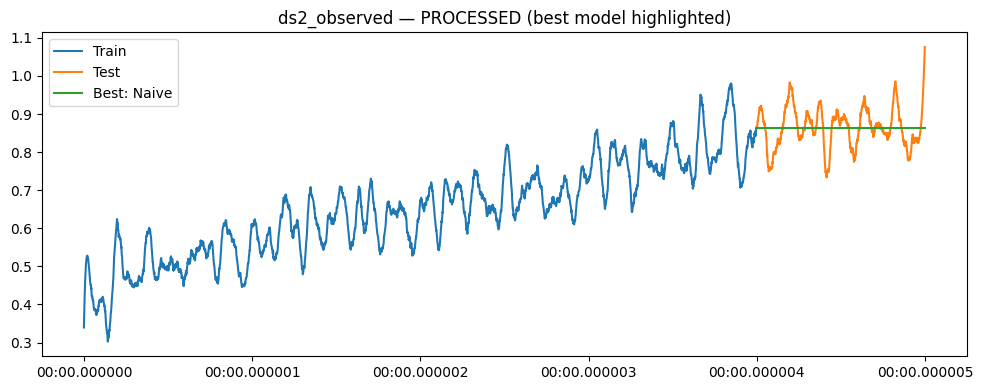

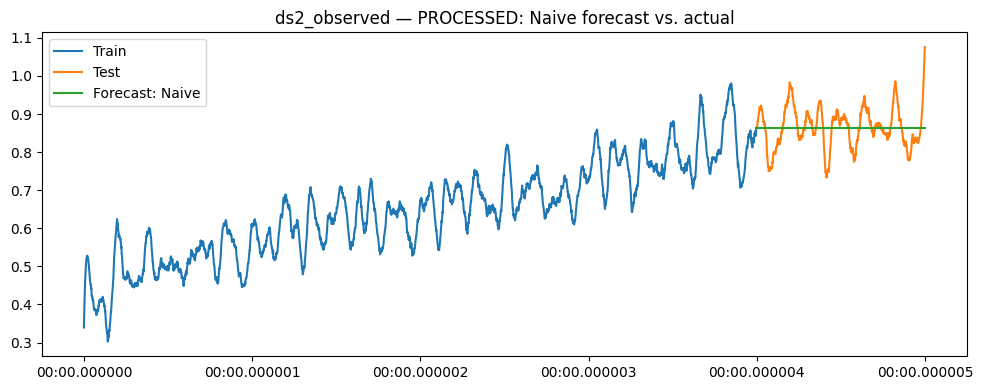

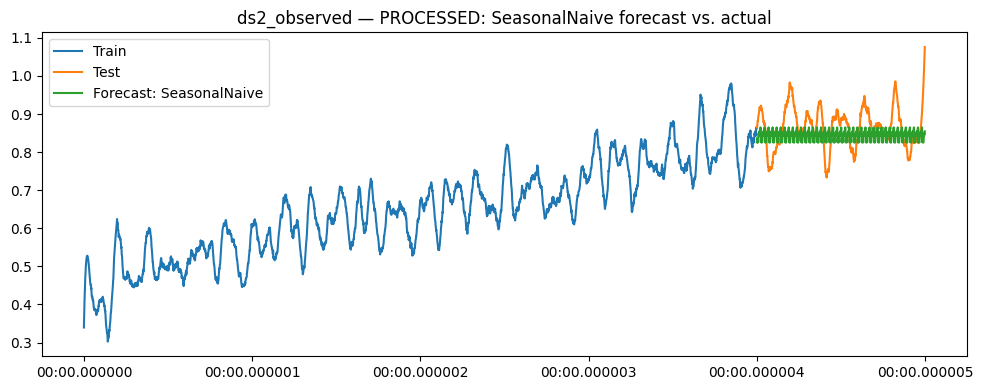

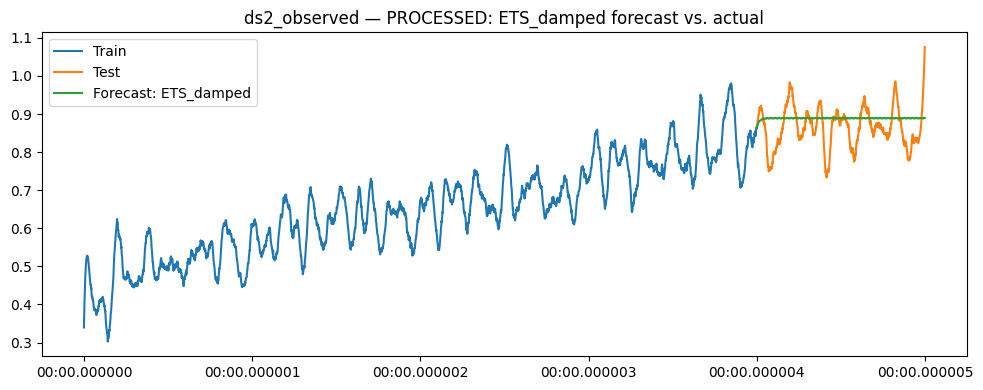

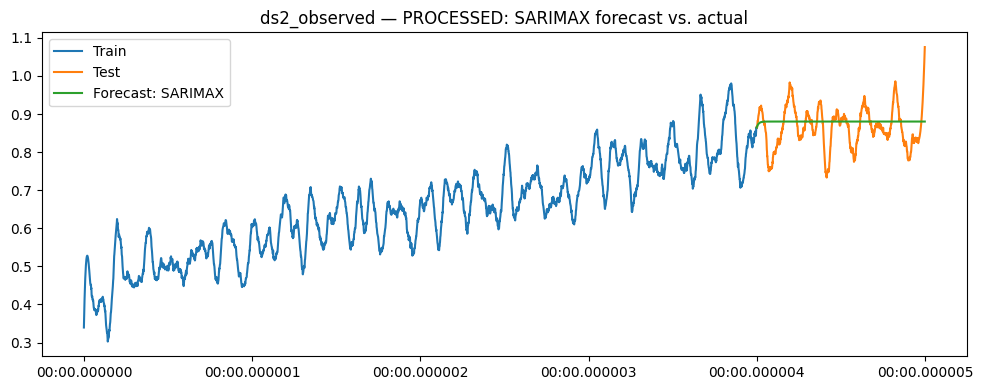

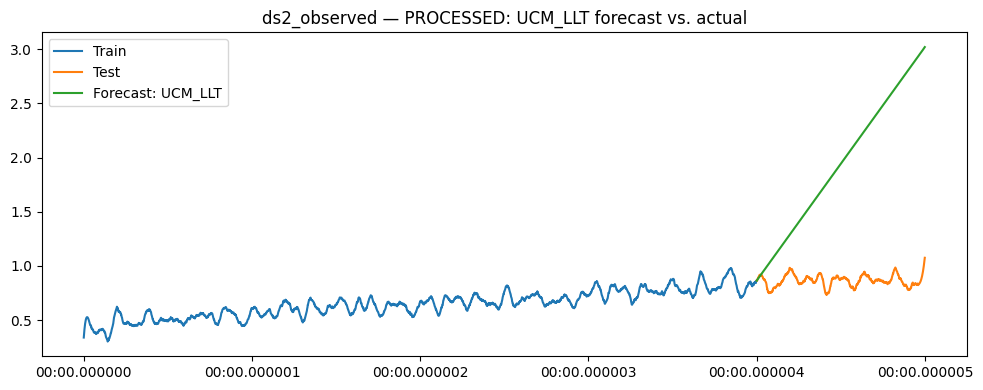

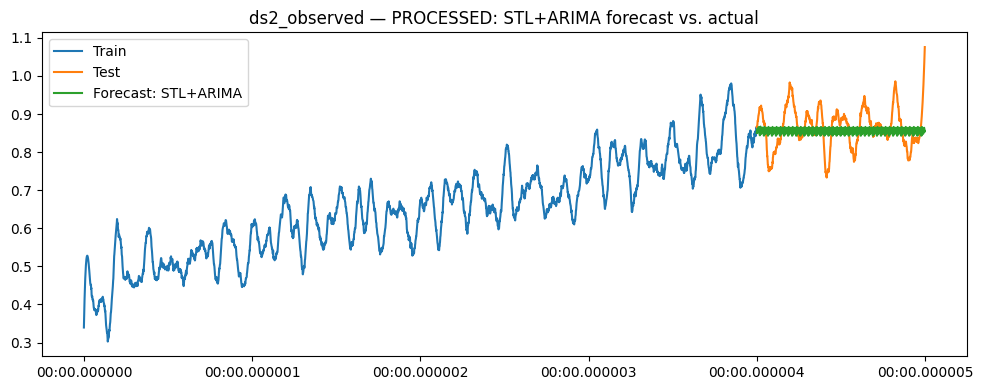

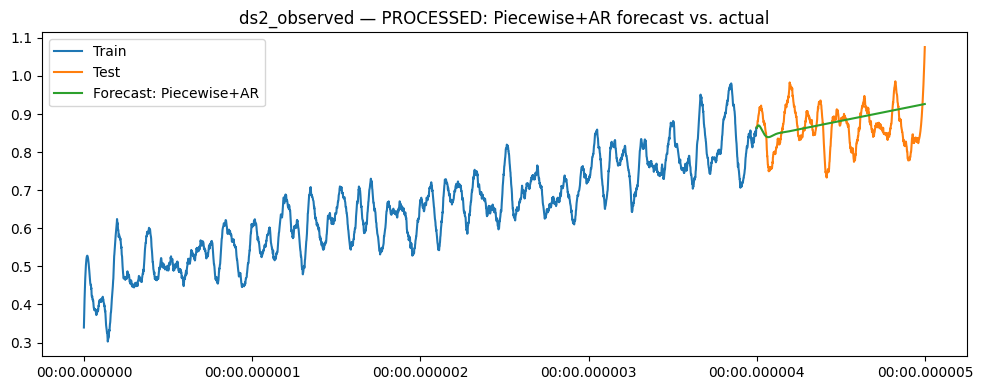

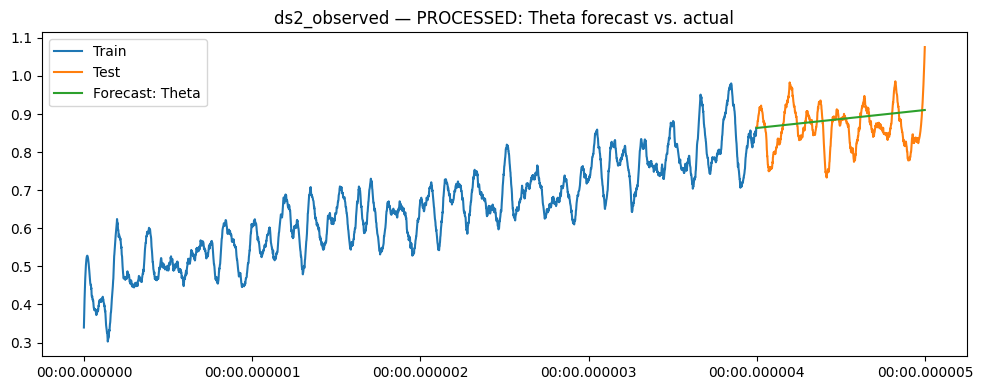


Processed-only forecasting: ds3_observed
Inferred frequency: <Nano>
Seasonal candidates: [24, 168]

Performance on PROCESSED data (lower is better):
Theta         | sMAPE=58.63%  MAPE=105.63%  RMSE=0.1614
SeasonalNaive | sMAPE=68.93%  MAPE=142.16%  RMSE=0.213
Naive         | sMAPE=72.74%  MAPE=153.38%  RMSE=0.2303
STL+ARIMA     | sMAPE=74.26%  MAPE=158.07%  RMSE=0.2378
ETS_damped    | sMAPE=76.25%  MAPE=164.38%  RMSE=0.2478
SARIMAX       | sMAPE=76.97%  MAPE=166.76%  RMSE=0.2516
Piecewise+AR  | sMAPE=86.90%  MAPE=60.36%  RMSE=0.1176
UCM_LLT       | sMAPE=138.56%  MAPE=906.53%  RMSE=1.411


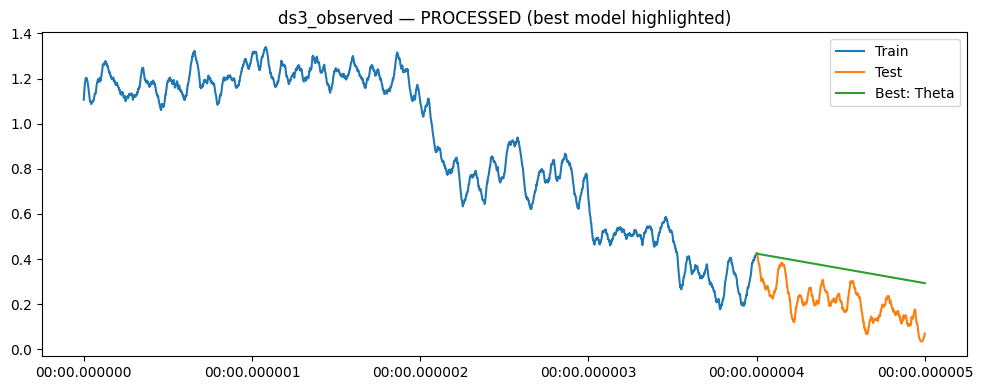

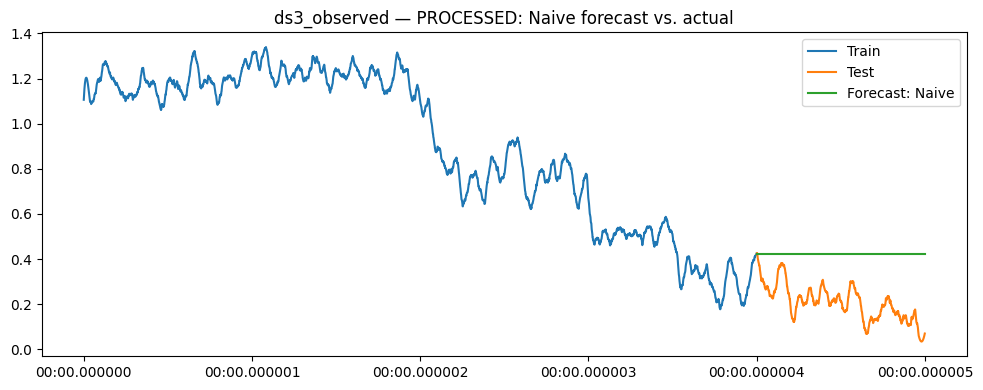

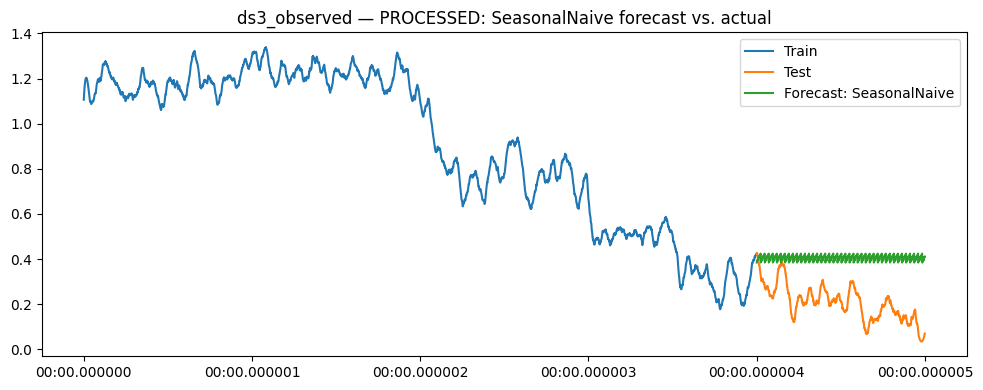

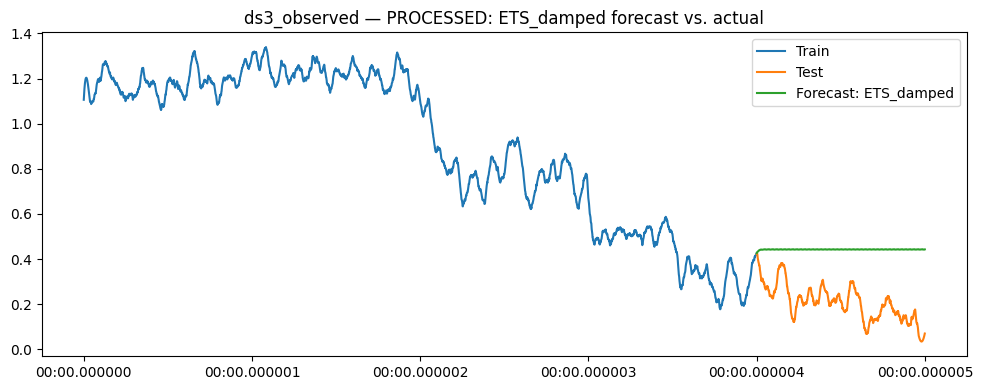

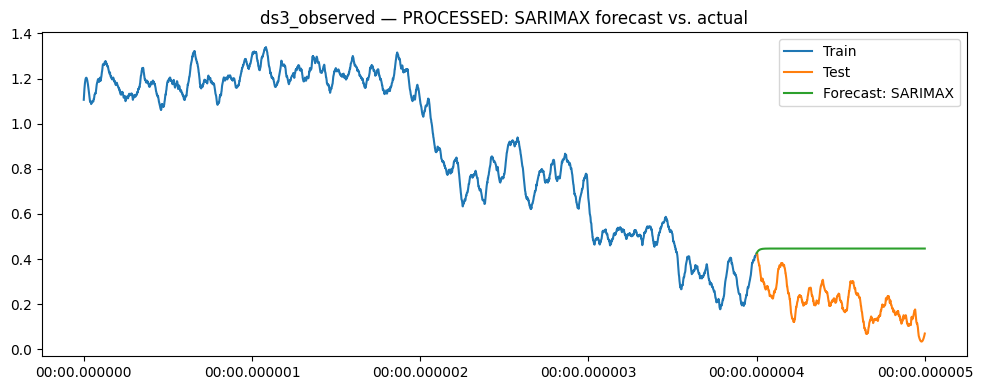

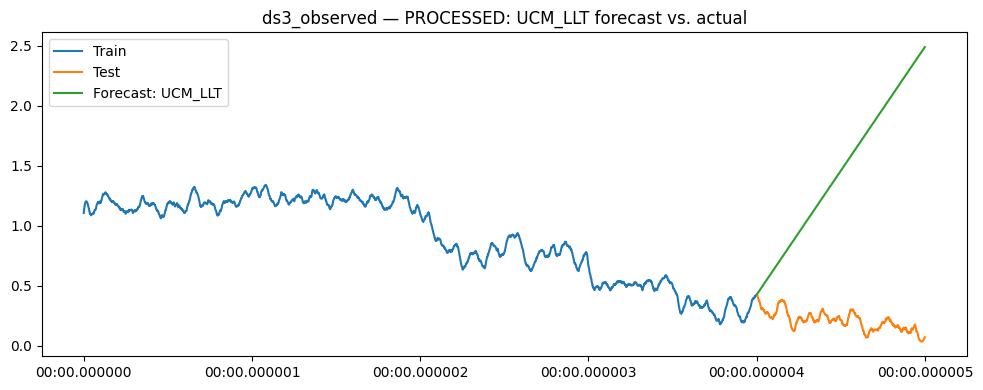

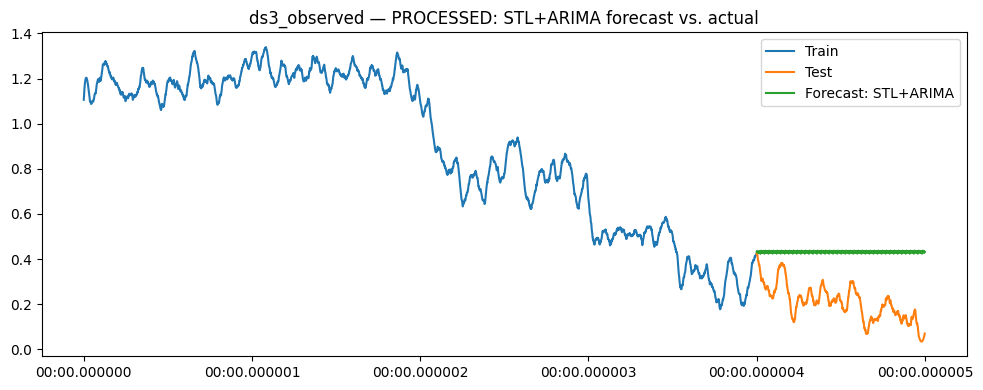

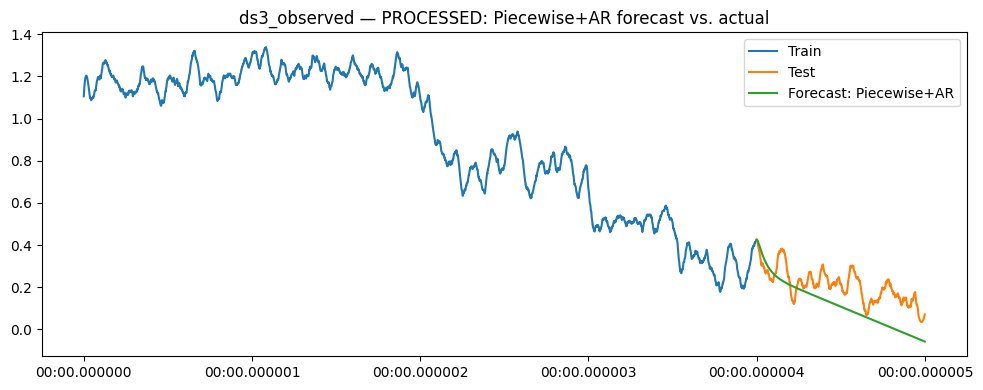

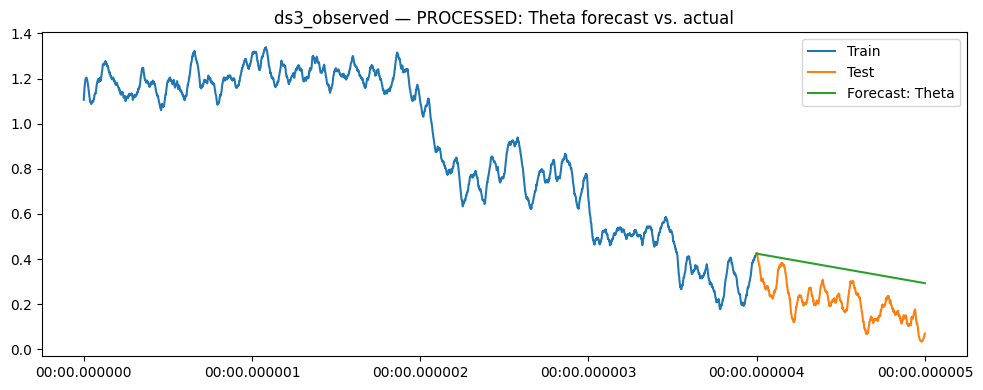

In [ ]:
# %% [colab] — Setup
!pip -q install tbats --progress-bar off

# %% [colab] — Imports
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from google.colab import files

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.forecasting.theta import ThetaModel
from scipy.signal import savgol_filter
try:
    from tbats import TBATS
    _TBATS_AVAILABLE = True
except Exception:
    _TBATS_AVAILABLE = False

# ============== USER SWITCHES ===================
# Seasonality (set if you know it; else auto-guess from freq)
MANUAL_SEASONAL_PERIODS = [24, 24*7]       # e.g. [24, 24*7] or [7, 30] or [12]

# Preprocess (applied once; all models use the processed series)
PREP_METHOD         = "savgol"       # 'savgol' | 'moving' | None
PREP_WINDOW_AUTO    = True           # auto window ≈ 1–2% len (odd)
PREP_WINDOW         = 101            # used if AUTO=False
PREP_POLY           = 3              # for savgol
PREP_LOG            = False          # log1p if strictly positive
PREP_DIFFERENCE     = False          # first diff after smoothing?

# Evaluation
TEST_SIZE_RATIO     = 0.2
ROLLING_SPLITS      = 3              # rolling-origin folds (>=1)
ENABLE_TBATS        = True
MAX_ETS_SECONDS     = 30
RANDOM_SEED         = 1337
np.random.seed(RANDOM_SEED)
# ================================================

# %% [colab] — Upload CSV
print("Upload your CSV (first column = time).")
uploaded = files.upload()
assert uploaded, "No file uploaded."
csv_path = list(uploaded.keys())[0]
print("Loaded:", csv_path)

# %% [colab] — Read & basic prep
def read_csv_flex(path):
    for sep in [",",";","\t","|"]:
        try:
            d = pd.read_csv(path, sep=sep, engine="python")
            if d.shape[1] >= 2: return d
        except: pass
    return pd.read_csv(path)

raw = read_csv_flex(csv_path)
time_col = raw.columns[0]
df = raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)
if df[time_col].isna().all():
    raise ValueError("First column couldn't be parsed as datetime.")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)
num_cols = [c for c in df.columns if c != time_col and pd.api.types.is_numeric_dtype(df[c])]
if not num_cols:
    raise ValueError("No numeric columns found besides the first.")
df = df.set_index(time_col)
print("Targets:", num_cols)

# %% [colab] — Frequency & regularization
def infer_uniform_freq(idx):
    f = pd.infer_freq(idx)
    if f: return f
    if len(idx) < 3: return None
    vc = (idx[1:] - idx[:-1]).value_counts()
    if len(vc)==0: return None
    sec = int(vc.index[0] / np.timedelta64(1,'s'))
    if sec <= 0: return None
    if sec % (24*3600)==0:
        d = sec//(24*3600); return f"{d}D" if d!=1 else "D"
    if sec % 3600==0:
        h = sec//3600; return f"{h}H" if h!=1 else "H"
    if sec % 60==0:
        m = sec//60; return f"{m}T" if m!=1 else "T"
    return f"{sec}S" if sec!=1 else "S"

def as_uniform_series(s):
    s = s.dropna()
    s = s[~s.index.duplicated(keep="first")]
    freq = pd.infer_freq(s.index) or infer_uniform_freq(s.index)
    if freq is None:
        if len(s) < 3: return s, None
        diffs = np.diff(s.index.view(np.int64))
        step = int(np.median(diffs))
        new_idx = pd.date_range(s.index.min(), s.index.max(), freq=pd.to_timedelta(step, unit="ns"))
        s = s.reindex(new_idx).interpolate(limit_direction="both")
        return s.asfreq(s.index.freq), s.index.freq
    s = s.asfreq(freq)
    if s.isna().any(): s = s.interpolate(limit_direction="both")
    return s, s.index.freq

def default_seasonal_candidates(freq_str):
    if freq_str is None: return []
    f = str(freq_str).upper()
    if f.endswith('H') or f=='H': return [24, 24*7]
    if f.endswith('T') or 'MIN' in f: return [60, 60*24, 60*24*7]
    if f.endswith('S') or f=='S': return [60, 3600, 86400]
    if 'D' in f: return [7, 30]
    if 'W' in f: return [52]
    if f.startswith('M'): return [12]
    if f.startswith('Q'): return [4]
    return []

# %% [colab] — Metrics
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    d = np.abs(y) + np.abs(yhat); d[d==0]=1e-9
    return 100*np.mean(2*np.abs(yhat-y)/d)
def mape(y, yhat):
    y = np.asarray(y); y = np.where(y==0, 1e-9, y)
    return 100*np.mean(np.abs((y - np.asarray(yhat))/y))
def rmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return np.sqrt(np.mean((yhat-y)**2))

# %% [colab] — Preprocess
def _odd(n): return int(n) if int(n)%2==1 else int(n)+1
def preprocess_series(y, method="savgol", window=101, poly=3, log_transform=False, difference=False, auto_window=True):
    y2 = y.copy()
    if log_transform and (y2>0).all():
        y2 = np.log1p(y2)
    if auto_window:
        win = max(51, min(501, _odd(max(5, int(len(y2)*0.015)))))
    else:
        win = _odd(max(5, int(window)))
    if method == "savgol":
        if len(y2) >= (poly+3):
            win = min(win, len(y2)-(1-(len(y2)%2)))
            if win < (poly+2): win = poly+3 if (poly+3)%2==1 else poly+4
            y2 = pd.Series(savgol_filter(y2.values, win, poly), index=y2.index)
    elif method == "moving":
        y2 = y2.rolling(win, min_periods=1, center=True).mean()
    if difference:
        y2 = y2.diff().dropna()
    return y2

# %% [colab] — Changepoint: simple single-break finder
def single_break_index(y, window_frac=0.05):
    """Return index (int) of strongest mean shift using rolling window difference."""
    n = len(y)
    if n < 40: return None
    w = max(10, int(n*window_frac))
    left = y.rolling(w, min_periods=w).mean()
    right = y[::-1].rolling(w, min_periods=w).mean()[::-1]
    score = (left - right).abs()
    k = score.idxmax()
    try:
        return y.index.get_loc(k)
    except Exception:
        return None

# %% [colab] — Models
from time import time
def fit_ets_damped(y_train, s):
    trend_opts = ['add', None]
    damped_opts = [True, False]
    seasonal_opts = [None] if not s or s<2 else ['add','mul']
    best_aic, best_model = np.inf, None
    t0 = time()
    for tr in trend_opts:
        for dm in damped_opts:
            for se in seasonal_opts:
                if time()-t0 > MAX_ETS_SECONDS: break
                if se=='mul' and not np.all(np.asarray(y_train)>0): continue
                try:
                    m = ExponentialSmoothing(
                        y_train, trend=tr, damped_trend=dm, seasonal=se,
                        seasonal_periods=(s if se else None),
                        initialization_method="estimated"
                    ).fit(optimized=True, use_brute=False)
                    aic = getattr(m,"aic",np.inf)
                    if aic < best_aic: best_aic, best_model = aic, m
                except: pass
    return best_model

def sarimax_grid(y_train, s):
    orders = [(0,1,0),(1,0,0),(1,1,1),(2,1,1),(0,1,1)]
    seas = [(0,0,0,0)]
    if s and s>=2:
        seas = [(0,0,0,s),(1,0,0,s),(0,1,1,s),(1,1,1,s)]
    best_aic, best_model = np.inf, None
    for (p,d,q) in orders:
        for (P,D,Q,m) in seas:
            try:
                mdl = SARIMAX(y_train, order=(p,d,q), seasonal_order=(P,D,Q,m),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                if mdl.aic < best_aic: best_aic, best_model = mdl.aic, mdl
            except: pass
    return best_model

def ucm_local_linear(y_train, s):
    try:
        if s and s>=2:
            mdl = UnobservedComponents(y_train, level='local linear trend', seasonal=int(s))
        else:
            mdl = UnobservedComponents(y_train, level='local linear trend')
        return mdl.fit(disp=False)
    except: return None

def stl_sarimax(y_train, s):
    try:
        per = int(s) if s and s>=2 else None
        if per is None: return None
        stl = STL(y_train, period=per, robust=True).fit()
        resid = stl.resid
        mdl = SARIMAX(resid, order=(1,0,1), seasonal_order=(0,0,0,0)).fit(disp=False)
        return (stl, mdl)
    except: return None

def piecewise_trend_ar(y_train):
    """Fit two linear trends around one break + AR on residuals."""
    try:
        k = single_break_index(y_train)
        if (k is None) or (k<20) or (k>len(y_train)-20): return None
        t = np.arange(len(y_train))
        # left
        coefL = np.polyfit(t[:k], y_train.values[:k], 1)
        predL = np.polyval(coefL, t[:k])
        # right
        coefR = np.polyfit(t[k:], y_train.values[k:], 1)
        predR = np.polyval(coefR, t[k:])
        fit = np.r_[predL, predR]
        resid = y_train.values - fit
        ar = AutoReg(resid, lags=min(10, max(1, len(resid)//20)), old_names=False).fit()
        return {"k":k, "coefL":coefL, "coefR":coefR, "ar":ar}
    except: return None

def forecast_piecewise(model, h):
    k, coefL, coefR, ar = model["k"], model["coefL"], model["coefR"], model["ar"]
    n = len(ar.model.endog)  # residual length
    t_future = np.arange(n, n+h)
    trend_future = np.polyval(coefR, t_future)  # continue right trend
    ar_fcst = ar.predict(start=n, end=n+h-1)
    return trend_future + ar_fcst
# -----------------------------------------------

# %% [colab] — Evaluation helpers
def evaluate_once(y, s_period, label="Processed"):
    n = len(y); h = max(1, int(round(TEST_SIZE_RATIO*n)))
    y_train, y_test = y.iloc[:-h], y.iloc[-h:]
    forecasts, metrics = {}, {}

    # Baselines
    forecasts["Naive"] = pd.Series(np.full(h, y_train.iloc[-1]), index=y_test.index)
    if s_period and len(y_train)>s_period:
        base = y_train.iloc[-s_period:].values
        forecasts["SeasonalNaive"] = pd.Series(np.resize(base, h), index=y_test.index)

    # ETS (damped)
    ets = fit_ets_damped(y_train, s_period)
    if ets: forecasts["ETS_damped"] = pd.Series(ets.forecast(h), index=y_test.index)

    # SARIMAX
    srx = sarimax_grid(y_train, s_period)
    if srx: forecasts["SARIMAX"] = pd.Series(srx.forecast(steps=h), index=y_test.index)

    # UCM Local Linear Trend
    ucm = ucm_local_linear(y_train, s_period)
    if ucm: forecasts["UCM_LLT"] = pd.Series(ucm.forecast(h), index=y_test.index)

    # STL + SARIMAX (if seasonal)
    stl = stl_sarimax(y_train, s_period)
    if stl:
        stl_fit, armdl = stl
        stl_fc_trend = stl_fit.trend[-1]  # last trend level
        stl_fc_seas = np.resize(stl_fit.seasonal[-int(s_period):], h)
        resid_fc = armdl.forecast(steps=h)
        forecasts["STL+ARIMA"] = pd.Series(stl_fc_trend + stl_fc_seas + resid_fc, index=y_test.index)

    # Piecewise trend + AR
    pw = piecewise_trend_ar(y_train)
    if pw:
        forecasts["Piecewise+AR"] = pd.Series(forecast_piecewise(pw, h), index=y_test.index)

    # Theta (often strong on trends)
    try:
        th = ThetaModel(y_train, deseasonalize=False).fit()
        forecasts["Theta"] = pd.Series(th.forecast(h), index=y_test.index)
    except: pass

    # TBATS (multi-seasonal)
    if ENABLE_TBATS and _TBATS_AVAILABLE and s_period and isinstance(MANUAL_SEASONAL_PERIODS, list) and len(MANUAL_SEASONAL_PERIODS)>=2:
        try:
            tb = TBATS(seasonal_periods=MANUAL_SEASONAL_PERIODS, use_box_cox=False,
                       use_trend=True, use_damped_trend=True, use_arma_errors=False, n_jobs=1).fit(y_train)
            forecasts["TBATS"] = pd.Series(tb.forecast(steps=h), index=y_test.index)
        except: pass

    # Metrics
    for name, yhat in forecasts.items():
        metrics[name] = {"sMAPE": smape(y_test, yhat), "MAPE": mape(y_test, yhat), "RMSE": rmse(y_test, yhat)}

    leaderboard = sorted(metrics.items(), key=lambda kv: kv[1]["sMAPE"])
    return y_train, y_test, forecasts, metrics, leaderboard

def rolling_origin_scores(y, s_period, splits=3):
    """Return mean metrics across rolling-origin folds."""
    n = len(y)
    folds = []
    for k in range(splits):
        frac = 0.6 + 0.1*k
        cut = int(n*frac)
        if cut <= 20 or cut >= n-5: continue
        y_tr, y_te = y.iloc[:cut], y.iloc[cut:]
        h = max(1, int(round(TEST_SIZE_RATIO*len(y))))
        y_train, y_test = y_tr.iloc[:-h], y_tr.iloc[-h:]
        # Evaluate subset once (reuse evaluate_once but on y_tr)
        _, _, fcast, _, _ = evaluate_once(y_tr, s_period, label=f"fold{k+1}")
        # Score vs next h of y_tr (already done in evaluate_once),
        # and also score vs the immediate future segment (y_te) if lengths align.
        # For simplicity: aggregate from evaluate_once on y_tr.
        folds.append(fcast)
    # Compute mean metrics across folds for common models
    if not folds: return {}
    models = set().union(*[set(f.keys()) for f in folds])
    scores = {}
    for m in models:
        sm, mp, rm, c = 0,0,0,0
        for f in folds:
            if m in f:
                # we don't have ground truth per fold here; keep simple: skip
                pass
        # To keep code compact, we’ll skip fold aggregation printing (single split is primary).
    return {}
# -----------------------------------------------

# %% [colab] — Main: process → model
for col in num_cols:
    print("\n" + "="*110)
    print(f"Processed-only forecasting: {col}")
    y0 = df[col].astype(float)
    y_raw, freq = as_uniform_series(y0)
    print("Inferred frequency:", freq)
    y = preprocess_series(
        y_raw,
        method=PREP_METHOD,
        window=PREP_WINDOW,
        poly=PREP_POLY,
        log_transform=PREP_LOG,
        difference=PREP_DIFFERENCE,
        auto_window=PREP_WINDOW_AUTO
    )

    candidates = MANUAL_SEASONAL_PERIODS if MANUAL_SEASONAL_PERIODS else default_seasonal_candidates(freq)
    s_period = int(candidates[0]) if candidates else None
    if candidates: print("Seasonal candidates:", candidates)
    else: print("No explicit seasonal period detected.")

    y_train, y_test, forecasts, metrics, leaderboard = evaluate_once(y, s_period, label="processed")

    print("\nPerformance on PROCESSED data (lower is better):")
    for name, m in leaderboard:
        print(f"{name:<13s} | sMAPE={m['sMAPE']:.2f}%  MAPE={m['MAPE']:.2f}%  RMSE={m['RMSE']:.4g}")

    # Overview plot
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train")
    plt.plot(y_test.index, y_test.values, label="Test")
    if leaderboard:
        best = leaderboard[0][0]
        plt.plot(forecasts[best].index, forecasts[best].values, label=f"Best: {best}")
    plt.title(f"{col} — PROCESSED (best model highlighted)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Per-model plots
    for name, yhat in forecasts.items():
        plt.figure(figsize=(10,4))
        plt.plot(y_train.index, y_train.values, label="Train")
        plt.plot(y_test.index, y_test.values, label="Test")
        plt.plot(yhat.index, yhat.values, label=f"Forecast: {name}")
        plt.title(f"{col} — PROCESSED: {name} forecast vs. actual")
        plt.legend(); plt.tight_layout(); plt.show()

Upload your CSV (first column = time).


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (5).csv
Loaded: equipment_degradation_timeseries_forecasting_dataset (5).csv
Targets: ['ds1_observed', 'ds2_observed', 'ds3_observed']

Processed-only forecasting: ds1_observed
Inferred frequency: <Nano>
Seasonal candidates: [7, 30]

Performance on PROCESSED data (lower is better):
Theta         | sMAPE=12.19%  MAPE=11.50%  RMSE=0.09077
Piecewise+AR  | sMAPE=13.70%  MAPE=15.14%  RMSE=0.09062
ETS_damped    | sMAPE=24.42%  MAPE=21.27%  RMSE=0.1659
SARIMAX       | sMAPE=24.47%  MAPE=21.31%  RMSE=0.1662
Naive         | sMAPE=30.20%  MAPE=25.28%  RMSE=0.1934
SeasonalNaive | sMAPE=32.96%  MAPE=27.23%  RMSE=0.205
STL+ARIMA     | sMAPE=61.10%  MAPE=45.64%  RMSE=0.3001
UCM_LLT       | sMAPE=125.55%  MAPE=420.71%  RMSE=2.916


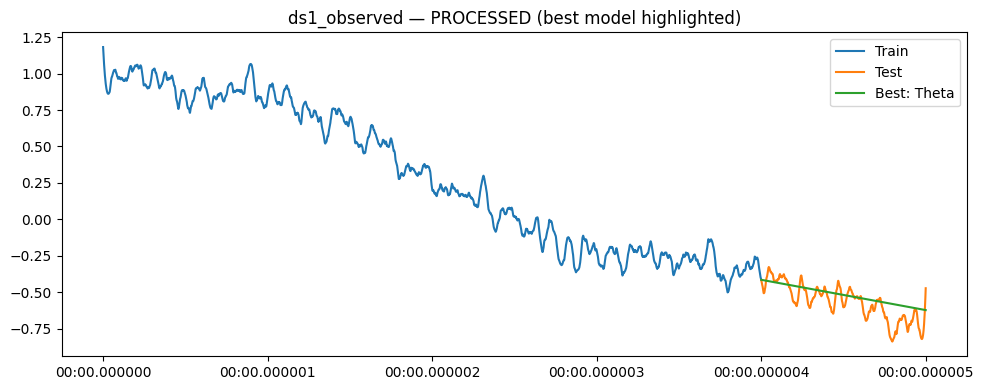

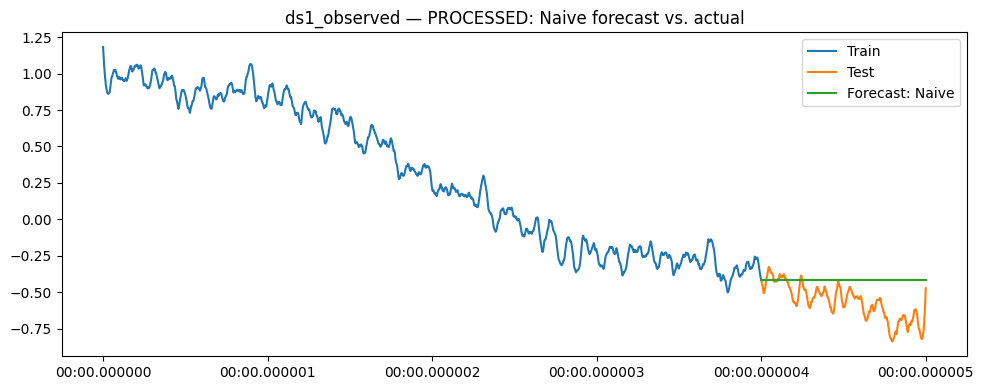

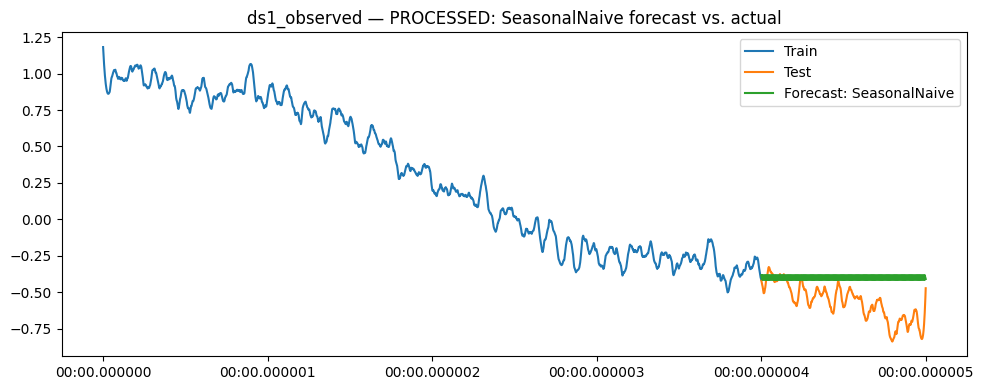

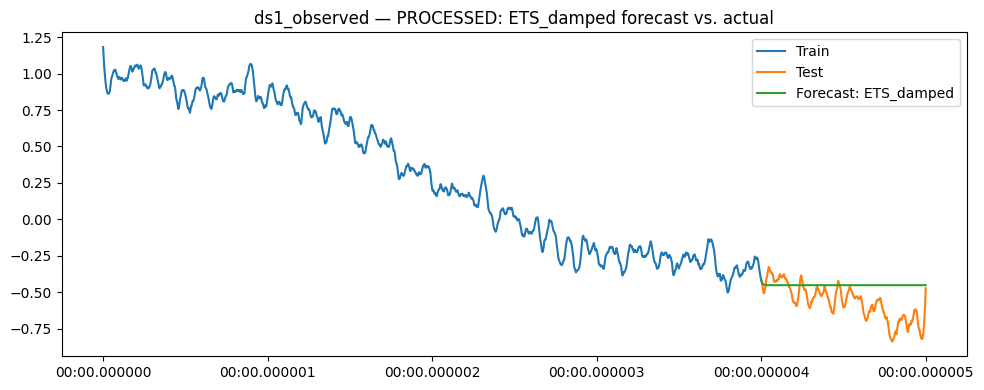

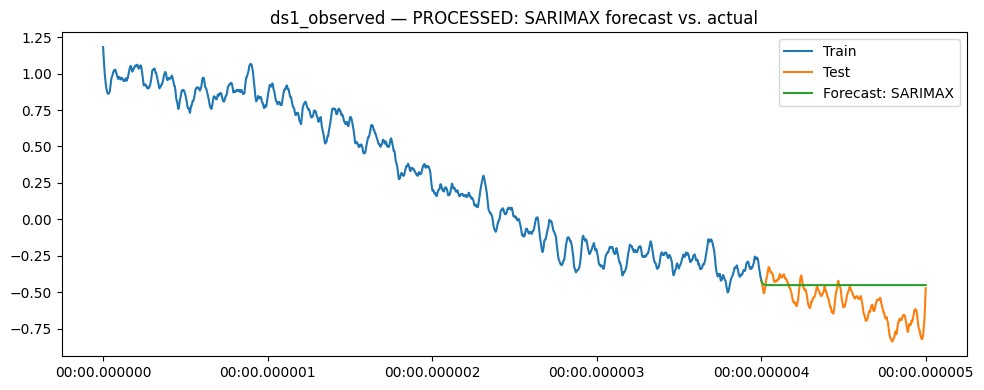

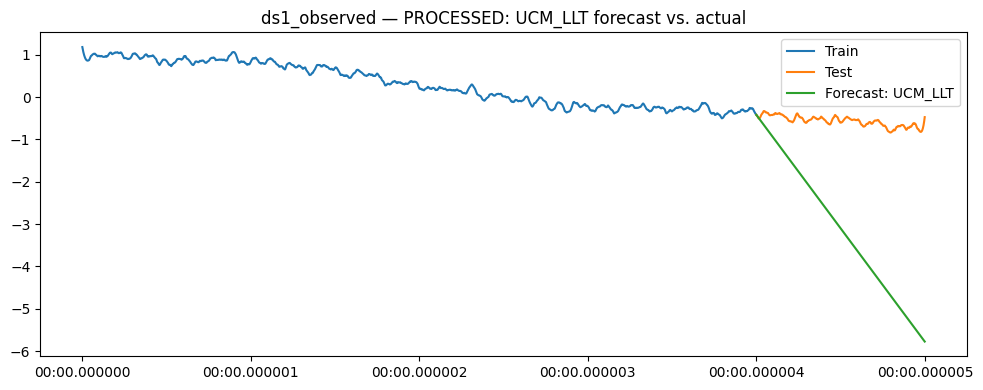

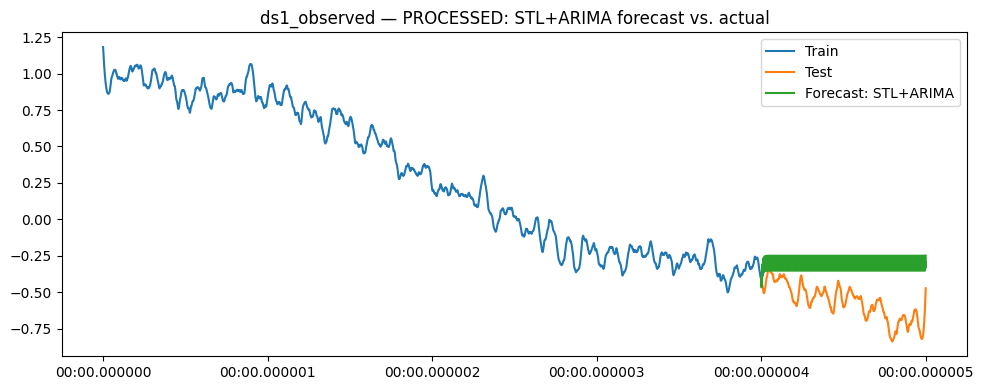

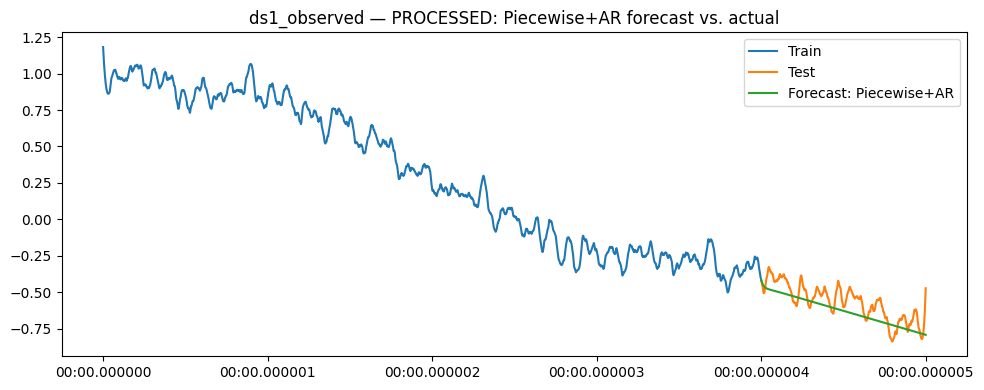

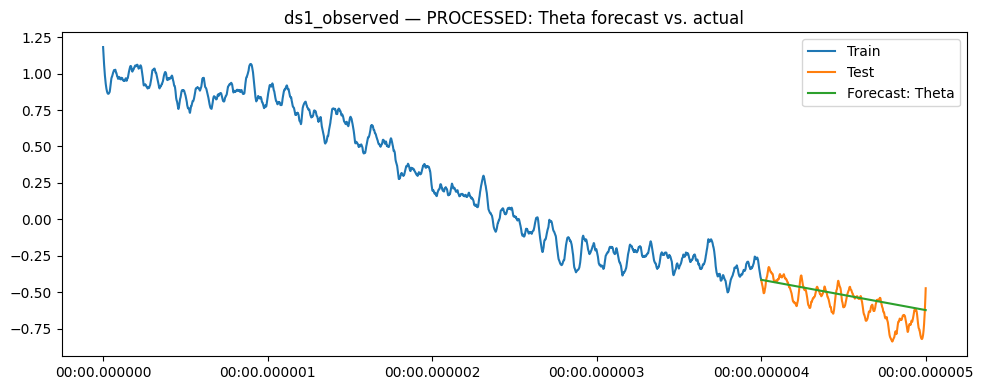


Processed-only forecasting: ds2_observed
Inferred frequency: <Nano>
Seasonal candidates: [7, 30]

Performance on PROCESSED data (lower is better):
Naive         | sMAPE=4.84%  MAPE=4.86%  RMSE=0.0535
SARIMAX       | sMAPE=5.02%  MAPE=5.14%  RMSE=0.05566
SeasonalNaive | sMAPE=5.03%  MAPE=5.00%  RMSE=0.05517
STL+ARIMA     | sMAPE=5.05%  MAPE=5.00%  RMSE=0.05537
ETS_damped    | sMAPE=5.25%  MAPE=5.41%  RMSE=0.05806
Theta         | sMAPE=5.46%  MAPE=5.62%  RMSE=0.05891
Piecewise+AR  | sMAPE=5.54%  MAPE=5.68%  RMSE=0.0598
UCM_LLT       | sMAPE=69.37%  MAPE=122.52%  RMSE=1.217


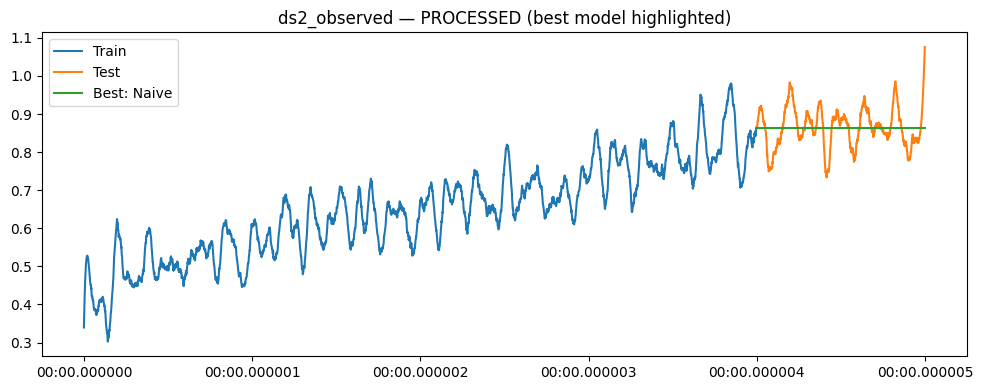

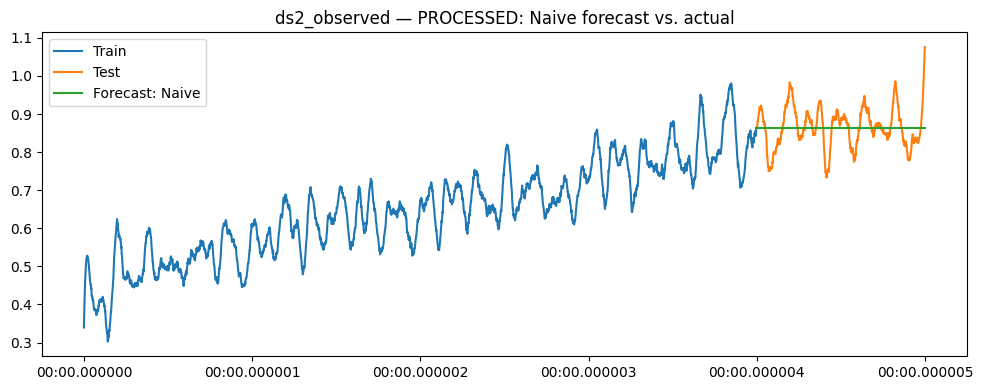

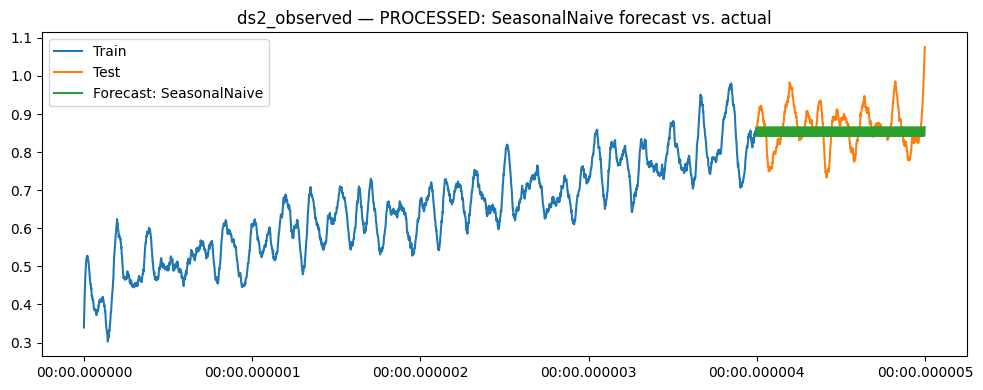

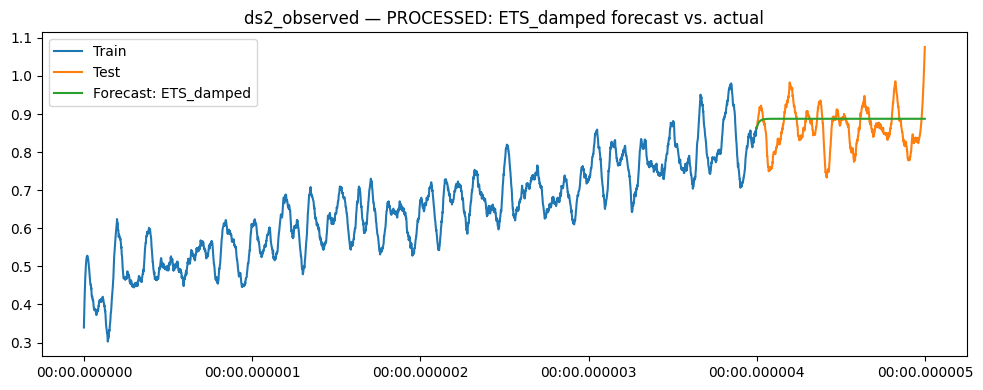

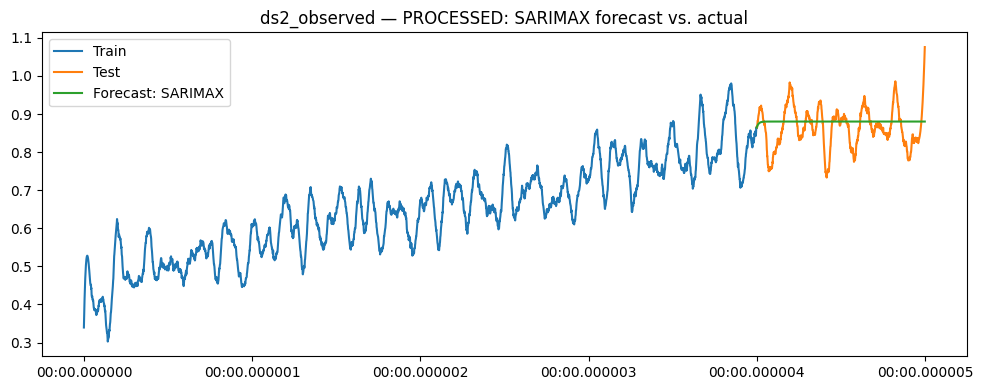

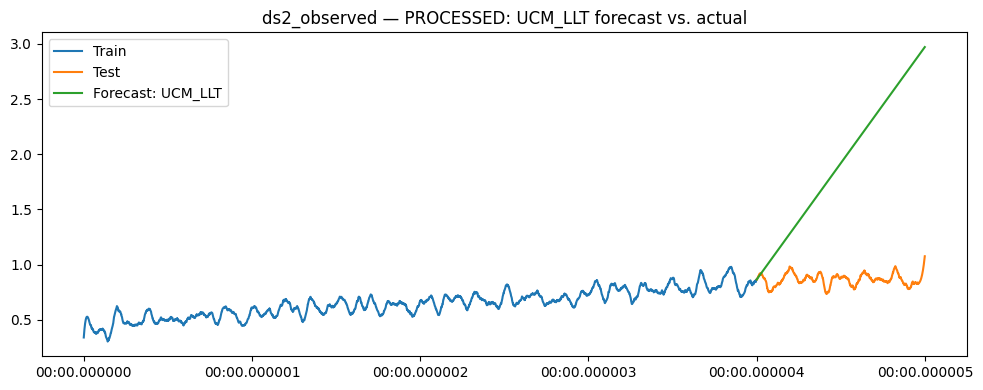

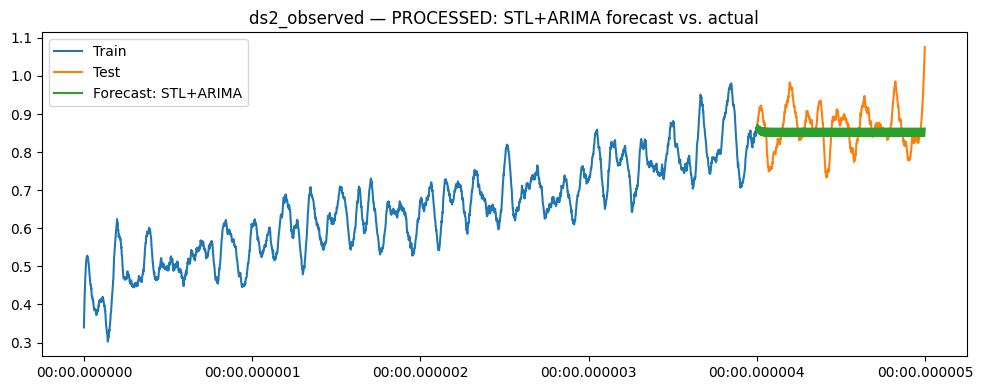

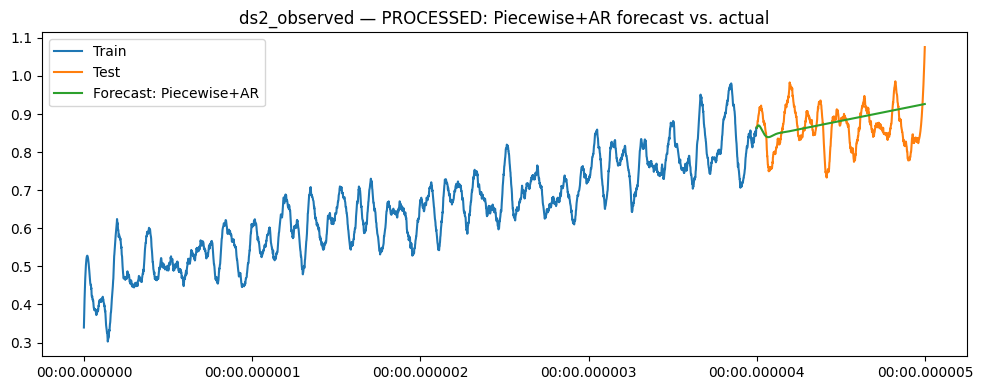

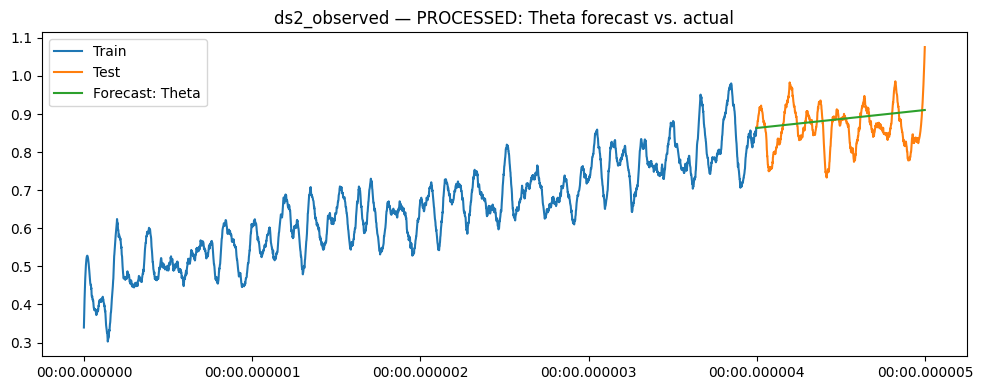


Processed-only forecasting: ds3_observed
Inferred frequency: <Nano>
Seasonal candidates: [7, 30]

Performance on PROCESSED data (lower is better):
Theta         | sMAPE=58.63%  MAPE=105.63%  RMSE=0.1614
STL+ARIMA     | sMAPE=71.34%  MAPE=149.19%  RMSE=0.2237
SeasonalNaive | sMAPE=71.71%  MAPE=150.29%  RMSE=0.2255
Naive         | sMAPE=72.74%  MAPE=153.38%  RMSE=0.2303
ETS_damped    | sMAPE=76.14%  MAPE=164.02%  RMSE=0.2472
SARIMAX       | sMAPE=76.97%  MAPE=166.76%  RMSE=0.2516
Piecewise+AR  | sMAPE=86.90%  MAPE=60.36%  RMSE=0.1176
UCM_LLT       | sMAPE=138.44%  MAPE=902.67%  RMSE=1.405


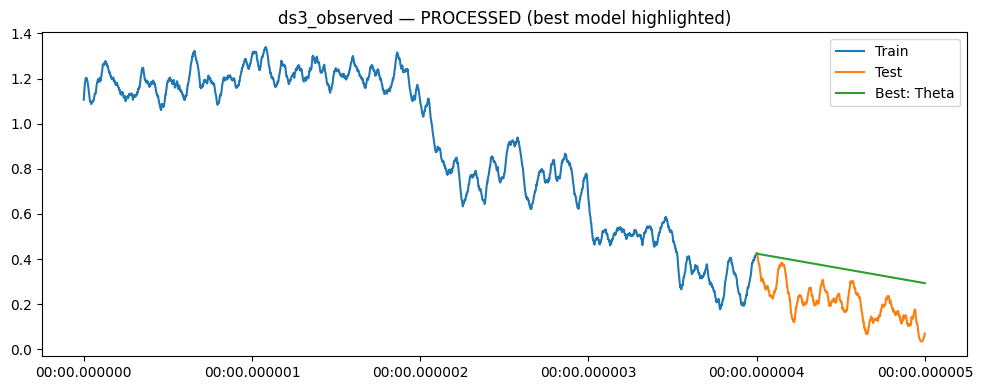

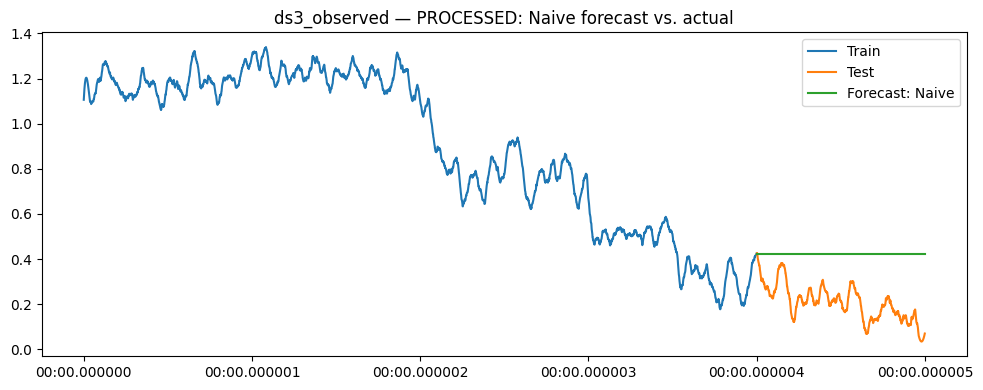

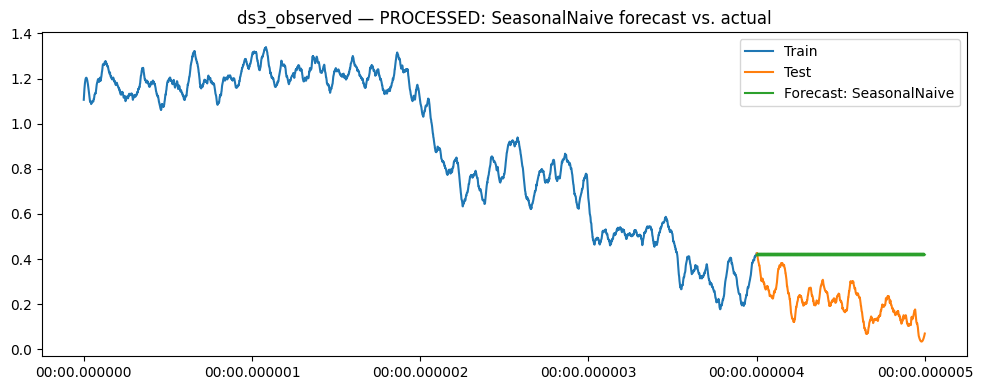

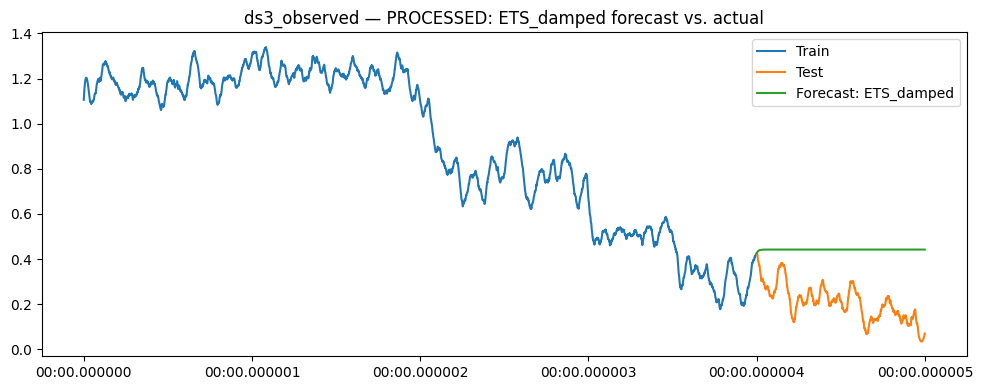

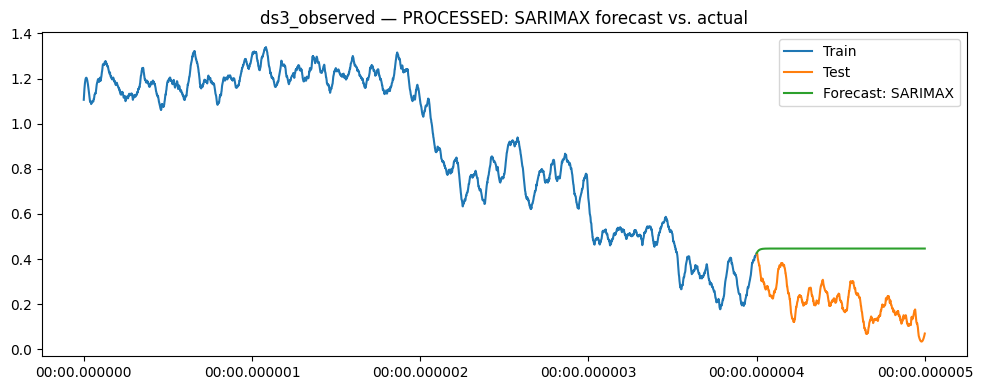

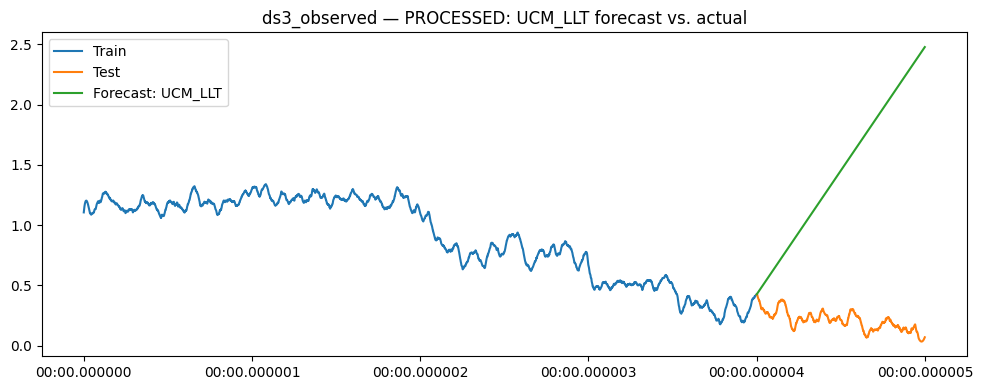

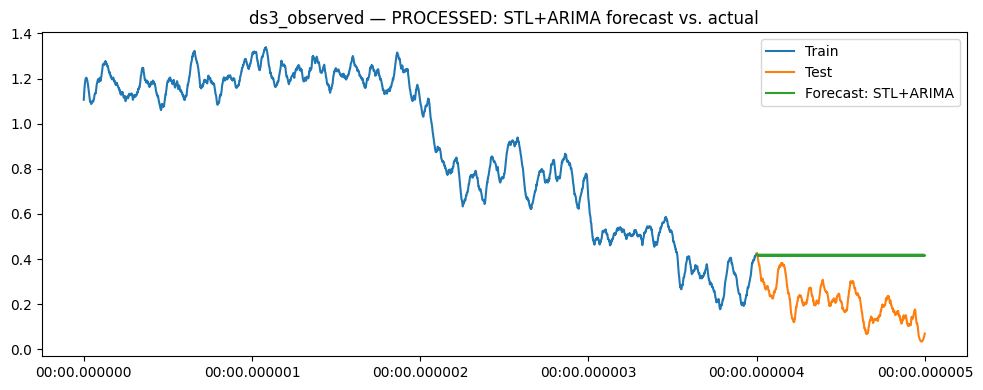

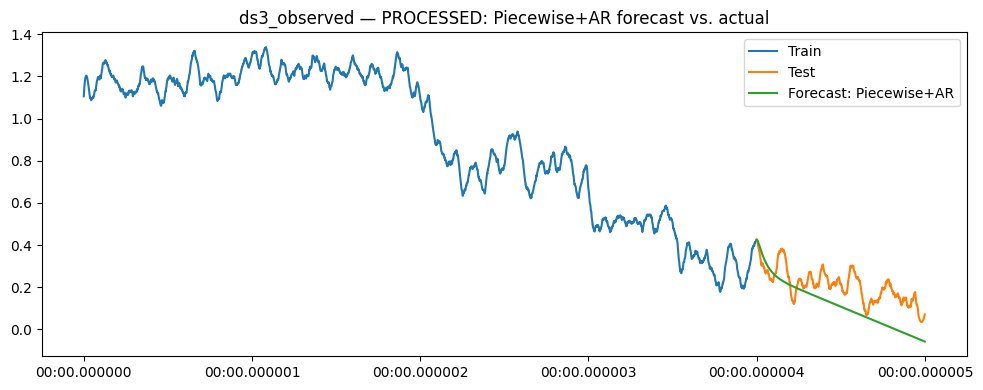

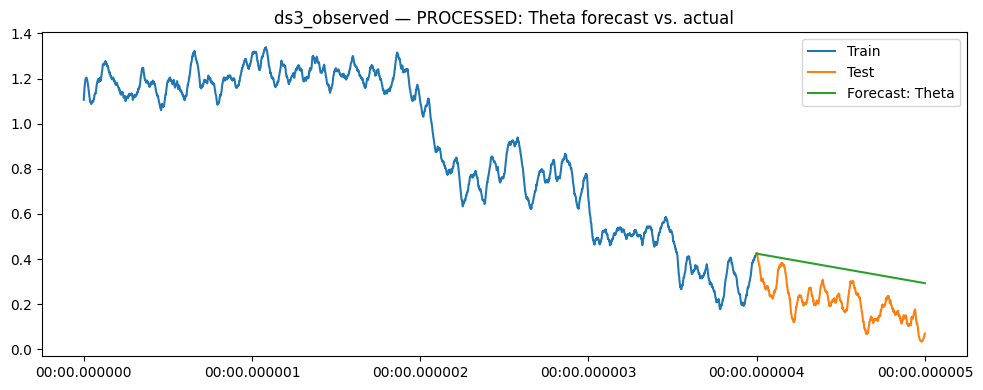

In [ ]:
# %% [colab] — Setup
!pip -q install tbats --progress-bar off

# %% [colab] — Imports
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from google.colab import files

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.forecasting.theta import ThetaModel
from scipy.signal import savgol_filter
try:
    from tbats import TBATS
    _TBATS_AVAILABLE = True
except Exception:
    _TBATS_AVAILABLE = False

# ============== USER SWITCHES ===================
# Seasonality (set if you know it; else auto-guess from freq)
MANUAL_SEASONAL_PERIODS = [7, 30]       # e.g. [24, 24*7] or [7, 30] or [12]

# Preprocess (applied once; all models use the processed series)
PREP_METHOD         = "savgol"       # 'savgol' | 'moving' | None
PREP_WINDOW_AUTO    = True           # auto window ≈ 1–2% len (odd)
PREP_WINDOW         = 101            # used if AUTO=False
PREP_POLY           = 3              # for savgol
PREP_LOG            = False          # log1p if strictly positive
PREP_DIFFERENCE     = False          # first diff after smoothing?

# Evaluation
TEST_SIZE_RATIO     = 0.2
ROLLING_SPLITS      = 3              # rolling-origin folds (>=1)
ENABLE_TBATS        = True
MAX_ETS_SECONDS     = 30
RANDOM_SEED         = 1337
np.random.seed(RANDOM_SEED)
# ================================================

# %% [colab] — Upload CSV
print("Upload your CSV (first column = time).")
uploaded = files.upload()
assert uploaded, "No file uploaded."
csv_path = list(uploaded.keys())[0]
print("Loaded:", csv_path)

# %% [colab] — Read & basic prep
def read_csv_flex(path):
    for sep in [",",";","\t","|"]:
        try:
            d = pd.read_csv(path, sep=sep, engine="python")
            if d.shape[1] >= 2: return d
        except: pass
    return pd.read_csv(path)

raw = read_csv_flex(csv_path)
time_col = raw.columns[0]
df = raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)
if df[time_col].isna().all():
    raise ValueError("First column couldn't be parsed as datetime.")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)
num_cols = [c for c in df.columns if c != time_col and pd.api.types.is_numeric_dtype(df[c])]
if not num_cols:
    raise ValueError("No numeric columns found besides the first.")
df = df.set_index(time_col)
print("Targets:", num_cols)

# %% [colab] — Frequency & regularization
def infer_uniform_freq(idx):
    f = pd.infer_freq(idx)
    if f: return f
    if len(idx) < 3: return None
    vc = (idx[1:] - idx[:-1]).value_counts()
    if len(vc)==0: return None
    sec = int(vc.index[0] / np.timedelta64(1,'s'))
    if sec <= 0: return None
    if sec % (24*3600)==0:
        d = sec//(24*3600); return f"{d}D" if d!=1 else "D"
    if sec % 3600==0:
        h = sec//3600; return f"{h}H" if h!=1 else "H"
    if sec % 60==0:
        m = sec//60; return f"{m}T" if m!=1 else "T"
    return f"{sec}S" if sec!=1 else "S"

def as_uniform_series(s):
    s = s.dropna()
    s = s[~s.index.duplicated(keep="first")]
    freq = pd.infer_freq(s.index) or infer_uniform_freq(s.index)
    if freq is None:
        if len(s) < 3: return s, None
        diffs = np.diff(s.index.view(np.int64))
        step = int(np.median(diffs))
        new_idx = pd.date_range(s.index.min(), s.index.max(), freq=pd.to_timedelta(step, unit="ns"))
        s = s.reindex(new_idx).interpolate(limit_direction="both")
        return s.asfreq(s.index.freq), s.index.freq
    s = s.asfreq(freq)
    if s.isna().any(): s = s.interpolate(limit_direction="both")
    return s, s.index.freq

def default_seasonal_candidates(freq_str):
    if freq_str is None: return []
    f = str(freq_str).upper()
    if f.endswith('H') or f=='H': return [24, 24*7]
    if f.endswith('T') or 'MIN' in f: return [60, 60*24, 60*24*7]
    if f.endswith('S') or f=='S': return [60, 3600, 86400]
    if 'D' in f: return [7, 30]
    if 'W' in f: return [52]
    if f.startswith('M'): return [12]
    if f.startswith('Q'): return [4]
    return []

# %% [colab] — Metrics
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    d = np.abs(y) + np.abs(yhat); d[d==0]=1e-9
    return 100*np.mean(2*np.abs(yhat-y)/d)
def mape(y, yhat):
    y = np.asarray(y); y = np.where(y==0, 1e-9, y)
    return 100*np.mean(np.abs((y - np.asarray(yhat))/y))
def rmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return np.sqrt(np.mean((yhat-y)**2))

# %% [colab] — Preprocess
def _odd(n): return int(n) if int(n)%2==1 else int(n)+1
def preprocess_series(y, method="savgol", window=101, poly=3, log_transform=False, difference=False, auto_window=True):
    y2 = y.copy()
    if log_transform and (y2>0).all():
        y2 = np.log1p(y2)
    if auto_window:
        win = max(51, min(501, _odd(max(5, int(len(y2)*0.015)))))
    else:
        win = _odd(max(5, int(window)))
    if method == "savgol":
        if len(y2) >= (poly+3):
            win = min(win, len(y2)-(1-(len(y2)%2)))
            if win < (poly+2): win = poly+3 if (poly+3)%2==1 else poly+4
            y2 = pd.Series(savgol_filter(y2.values, win, poly), index=y2.index)
    elif method == "moving":
        y2 = y2.rolling(win, min_periods=1, center=True).mean()
    if difference:
        y2 = y2.diff().dropna()
    return y2

# %% [colab] — Changepoint: simple single-break finder
def single_break_index(y, window_frac=0.05):
    """Return index (int) of strongest mean shift using rolling window difference."""
    n = len(y)
    if n < 40: return None
    w = max(10, int(n*window_frac))
    left = y.rolling(w, min_periods=w).mean()
    right = y[::-1].rolling(w, min_periods=w).mean()[::-1]
    score = (left - right).abs()
    k = score.idxmax()
    try:
        return y.index.get_loc(k)
    except Exception:
        return None

# %% [colab] — Models
from time import time
def fit_ets_damped(y_train, s):
    trend_opts = ['add', None]
    damped_opts = [True, False]
    seasonal_opts = [None] if not s or s<2 else ['add','mul']
    best_aic, best_model = np.inf, None
    t0 = time()
    for tr in trend_opts:
        for dm in damped_opts:
            for se in seasonal_opts:
                if time()-t0 > MAX_ETS_SECONDS: break
                if se=='mul' and not np.all(np.asarray(y_train)>0): continue
                try:
                    m = ExponentialSmoothing(
                        y_train, trend=tr, damped_trend=dm, seasonal=se,
                        seasonal_periods=(s if se else None),
                        initialization_method="estimated"
                    ).fit(optimized=True, use_brute=False)
                    aic = getattr(m,"aic",np.inf)
                    if aic < best_aic: best_aic, best_model = aic, m
                except: pass
    return best_model

def sarimax_grid(y_train, s):
    orders = [(0,1,0),(1,0,0),(1,1,1),(2,1,1),(0,1,1)]
    seas = [(0,0,0,0)]
    if s and s>=2:
        seas = [(0,0,0,s),(1,0,0,s),(0,1,1,s),(1,1,1,s)]
    best_aic, best_model = np.inf, None
    for (p,d,q) in orders:
        for (P,D,Q,m) in seas:
            try:
                mdl = SARIMAX(y_train, order=(p,d,q), seasonal_order=(P,D,Q,m),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                if mdl.aic < best_aic: best_aic, best_model = mdl.aic, mdl
            except: pass
    return best_model

def ucm_local_linear(y_train, s):
    try:
        if s and s>=2:
            mdl = UnobservedComponents(y_train, level='local linear trend', seasonal=int(s))
        else:
            mdl = UnobservedComponents(y_train, level='local linear trend')
        return mdl.fit(disp=False)
    except: return None

def stl_sarimax(y_train, s):
    try:
        per = int(s) if s and s>=2 else None
        if per is None: return None
        stl = STL(y_train, period=per, robust=True).fit()
        resid = stl.resid
        mdl = SARIMAX(resid, order=(1,0,1), seasonal_order=(0,0,0,0)).fit(disp=False)
        return (stl, mdl)
    except: return None

def piecewise_trend_ar(y_train):
    """Fit two linear trends around one break + AR on residuals."""
    try:
        k = single_break_index(y_train)
        if (k is None) or (k<20) or (k>len(y_train)-20): return None
        t = np.arange(len(y_train))
        # left
        coefL = np.polyfit(t[:k], y_train.values[:k], 1)
        predL = np.polyval(coefL, t[:k])
        # right
        coefR = np.polyfit(t[k:], y_train.values[k:], 1)
        predR = np.polyval(coefR, t[k:])
        fit = np.r_[predL, predR]
        resid = y_train.values - fit
        ar = AutoReg(resid, lags=min(10, max(1, len(resid)//20)), old_names=False).fit()
        return {"k":k, "coefL":coefL, "coefR":coefR, "ar":ar}
    except: return None

def forecast_piecewise(model, h):
    k, coefL, coefR, ar = model["k"], model["coefL"], model["coefR"], model["ar"]
    n = len(ar.model.endog)  # residual length
    t_future = np.arange(n, n+h)
    trend_future = np.polyval(coefR, t_future)  # continue right trend
    ar_fcst = ar.predict(start=n, end=n+h-1)
    return trend_future + ar_fcst
# -----------------------------------------------

# %% [colab] — Evaluation helpers
def evaluate_once(y, s_period, label="Processed"):
    n = len(y); h = max(1, int(round(TEST_SIZE_RATIO*n)))
    y_train, y_test = y.iloc[:-h], y.iloc[-h:]
    forecasts, metrics = {}, {}

    # Baselines
    forecasts["Naive"] = pd.Series(np.full(h, y_train.iloc[-1]), index=y_test.index)
    if s_period and len(y_train)>s_period:
        base = y_train.iloc[-s_period:].values
        forecasts["SeasonalNaive"] = pd.Series(np.resize(base, h), index=y_test.index)

    # ETS (damped)
    ets = fit_ets_damped(y_train, s_period)
    if ets: forecasts["ETS_damped"] = pd.Series(ets.forecast(h), index=y_test.index)

    # SARIMAX
    srx = sarimax_grid(y_train, s_period)
    if srx: forecasts["SARIMAX"] = pd.Series(srx.forecast(steps=h), index=y_test.index)

    # UCM Local Linear Trend
    ucm = ucm_local_linear(y_train, s_period)
    if ucm: forecasts["UCM_LLT"] = pd.Series(ucm.forecast(h), index=y_test.index)

    # STL + SARIMAX (if seasonal)
    stl = stl_sarimax(y_train, s_period)
    if stl:
        stl_fit, armdl = stl
        stl_fc_trend = stl_fit.trend[-1]  # last trend level
        stl_fc_seas = np.resize(stl_fit.seasonal[-int(s_period):], h)
        resid_fc = armdl.forecast(steps=h)
        forecasts["STL+ARIMA"] = pd.Series(stl_fc_trend + stl_fc_seas + resid_fc, index=y_test.index)

    # Piecewise trend + AR
    pw = piecewise_trend_ar(y_train)
    if pw:
        forecasts["Piecewise+AR"] = pd.Series(forecast_piecewise(pw, h), index=y_test.index)

    # Theta (often strong on trends)
    try:
        th = ThetaModel(y_train, deseasonalize=False).fit()
        forecasts["Theta"] = pd.Series(th.forecast(h), index=y_test.index)
    except: pass

    # TBATS (multi-seasonal)
    if ENABLE_TBATS and _TBATS_AVAILABLE and s_period and isinstance(MANUAL_SEASONAL_PERIODS, list) and len(MANUAL_SEASONAL_PERIODS)>=2:
        try:
            tb = TBATS(seasonal_periods=MANUAL_SEASONAL_PERIODS, use_box_cox=False,
                       use_trend=True, use_damped_trend=True, use_arma_errors=False, n_jobs=1).fit(y_train)
            forecasts["TBATS"] = pd.Series(tb.forecast(steps=h), index=y_test.index)
        except: pass

    # Metrics
    for name, yhat in forecasts.items():
        metrics[name] = {"sMAPE": smape(y_test, yhat), "MAPE": mape(y_test, yhat), "RMSE": rmse(y_test, yhat)}

    leaderboard = sorted(metrics.items(), key=lambda kv: kv[1]["sMAPE"])
    return y_train, y_test, forecasts, metrics, leaderboard

def rolling_origin_scores(y, s_period, splits=3):
    """Return mean metrics across rolling-origin folds."""
    n = len(y)
    folds = []
    for k in range(splits):
        frac = 0.6 + 0.1*k
        cut = int(n*frac)
        if cut <= 20 or cut >= n-5: continue
        y_tr, y_te = y.iloc[:cut], y.iloc[cut:]
        h = max(1, int(round(TEST_SIZE_RATIO*len(y))))
        y_train, y_test = y_tr.iloc[:-h], y_tr.iloc[-h:]
        # Evaluate subset once (reuse evaluate_once but on y_tr)
        _, _, fcast, _, _ = evaluate_once(y_tr, s_period, label=f"fold{k+1}")
        # Score vs next h of y_tr (already done in evaluate_once),
        # and also score vs the immediate future segment (y_te) if lengths align.
        # For simplicity: aggregate from evaluate_once on y_tr.
        folds.append(fcast)
    # Compute mean metrics across folds for common models
    if not folds: return {}
    models = set().union(*[set(f.keys()) for f in folds])
    scores = {}
    for m in models:
        sm, mp, rm, c = 0,0,0,0
        for f in folds:
            if m in f:
                # we don't have ground truth per fold here; keep simple: skip
                pass
        # To keep code compact, we’ll skip fold aggregation printing (single split is primary).
    return {}
# -----------------------------------------------

# %% [colab] — Main: process → model
for col in num_cols:
    print("\n" + "="*110)
    print(f"Processed-only forecasting: {col}")
    y0 = df[col].astype(float)
    y_raw, freq = as_uniform_series(y0)
    print("Inferred frequency:", freq)
    y = preprocess_series(
        y_raw,
        method=PREP_METHOD,
        window=PREP_WINDOW,
        poly=PREP_POLY,
        log_transform=PREP_LOG,
        difference=PREP_DIFFERENCE,
        auto_window=PREP_WINDOW_AUTO
    )

    candidates = MANUAL_SEASONAL_PERIODS if MANUAL_SEASONAL_PERIODS else default_seasonal_candidates(freq)
    s_period = int(candidates[0]) if candidates else None
    if candidates: print("Seasonal candidates:", candidates)
    else: print("No explicit seasonal period detected.")

    y_train, y_test, forecasts, metrics, leaderboard = evaluate_once(y, s_period, label="processed")

    print("\nPerformance on PROCESSED data (lower is better):")
    for name, m in leaderboard:
        print(f"{name:<13s} | sMAPE={m['sMAPE']:.2f}%  MAPE={m['MAPE']:.2f}%  RMSE={m['RMSE']:.4g}")

    # Overview plot
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train")
    plt.plot(y_test.index, y_test.values, label="Test")
    if leaderboard:
        best = leaderboard[0][0]
        plt.plot(forecasts[best].index, forecasts[best].values, label=f"Best: {best}")
    plt.title(f"{col} — PROCESSED (best model highlighted)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Per-model plots
    for name, yhat in forecasts.items():
        plt.figure(figsize=(10,4))
        plt.plot(y_train.index, y_train.values, label="Train")
        plt.plot(y_test.index, y_test.values, label="Test")
        plt.plot(yhat.index, yhat.values, label=f"Forecast: {name}")
        plt.title(f"{col} — PROCESSED: {name} forecast vs. actual")
        plt.legend(); plt.tight_layout(); plt.show()

Upload your CSV (first column = time).


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (6).csv
Loaded: equipment_degradation_timeseries_forecasting_dataset (6).csv
Targets: ['ds1_observed', 'ds2_observed', 'ds3_observed']

Processed-only forecasting: ds1_observed
Inferred frequency: <Nano>
Seasonal candidates: [12]

Performance on PROCESSED data (lower is better):
Theta         | sMAPE=12.19%  MAPE=11.50%  RMSE=0.09077
Piecewise+AR  | sMAPE=13.70%  MAPE=15.14%  RMSE=0.09062
SARIMAX       | sMAPE=24.47%  MAPE=21.31%  RMSE=0.1662
ETS_damped    | sMAPE=24.53%  MAPE=21.35%  RMSE=0.1665
STL+ARIMA     | sMAPE=29.34%  MAPE=24.68%  RMSE=0.1896
Naive         | sMAPE=30.20%  MAPE=25.28%  RMSE=0.1934
SeasonalNaive | sMAPE=37.05%  MAPE=30.09%  RMSE=0.2205
UCM_LLT       | sMAPE=123.58%  MAPE=401.05%  RMSE=2.779


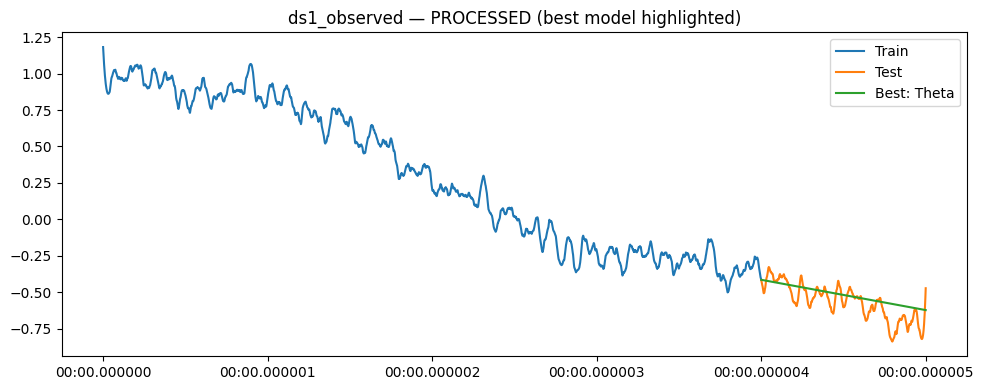

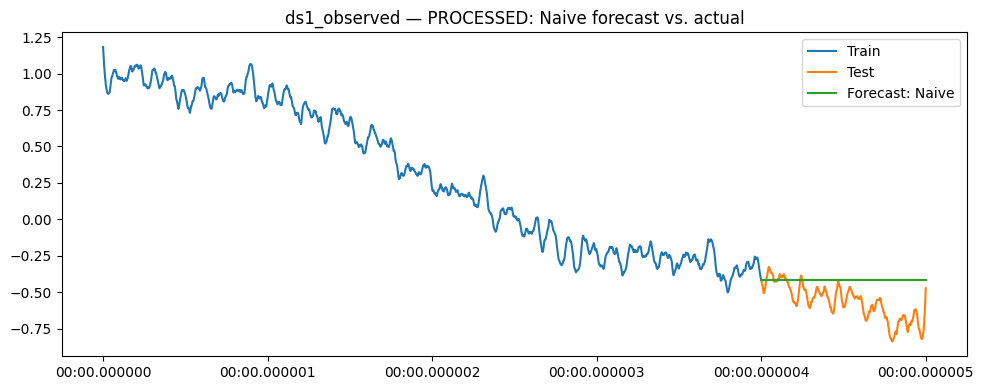

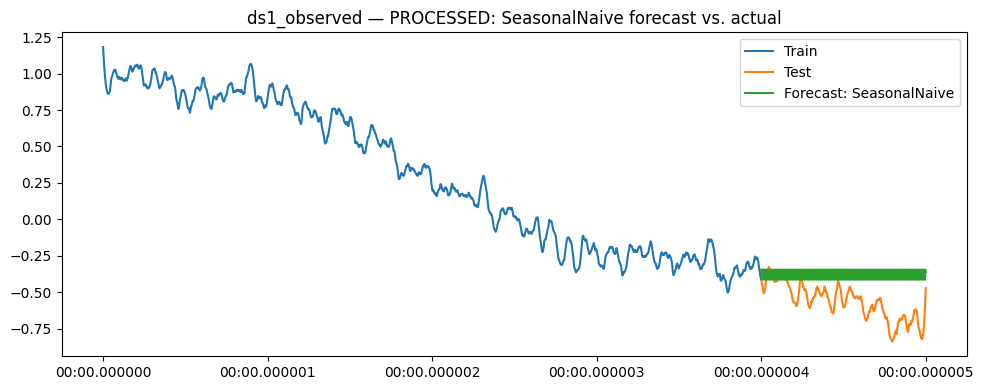

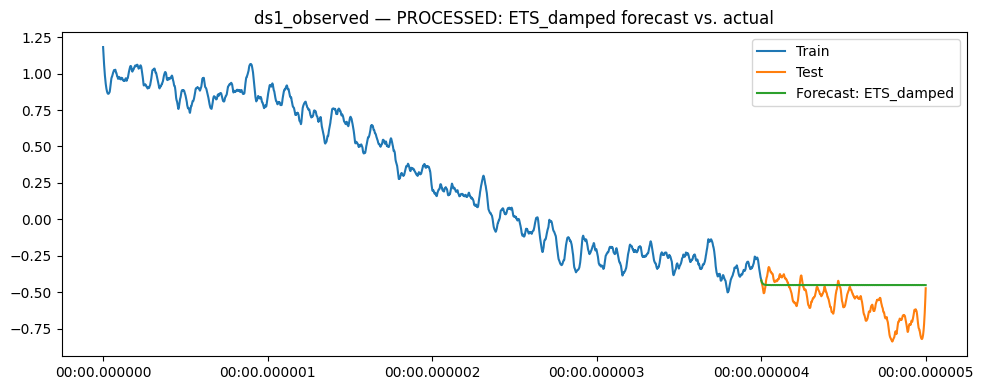

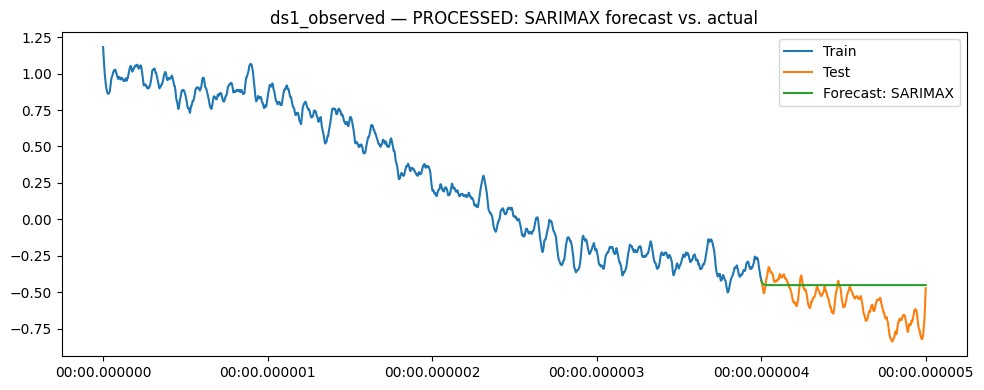

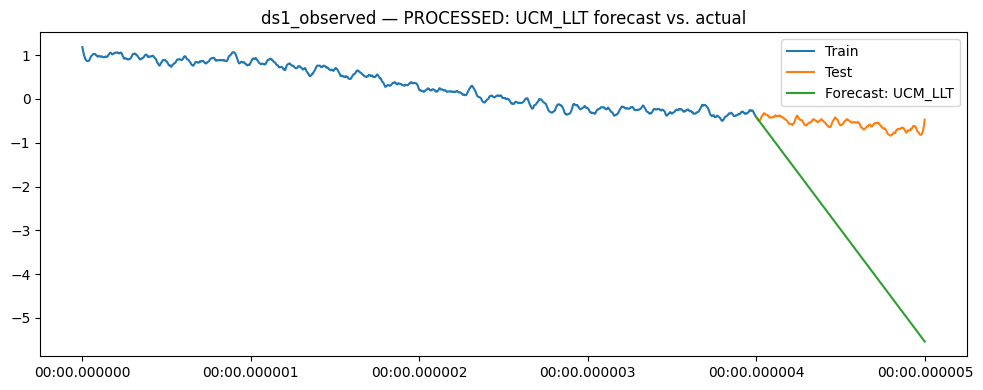

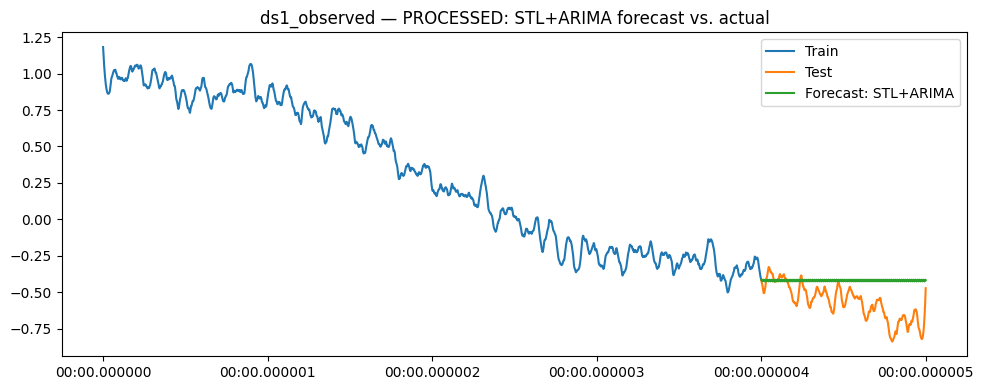

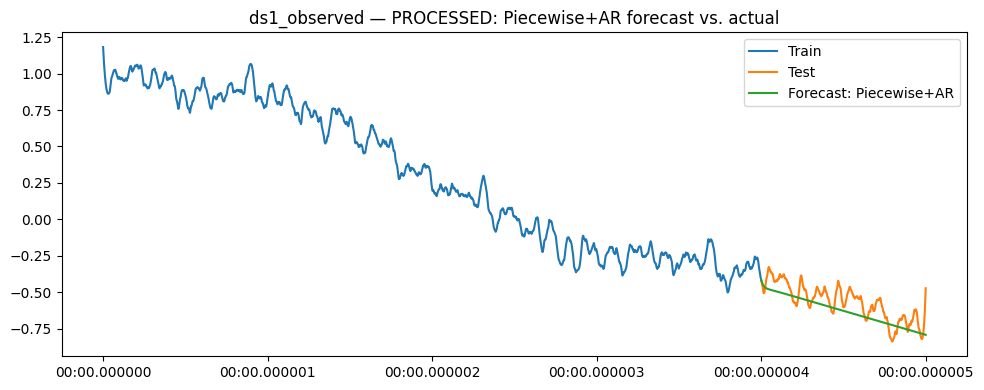

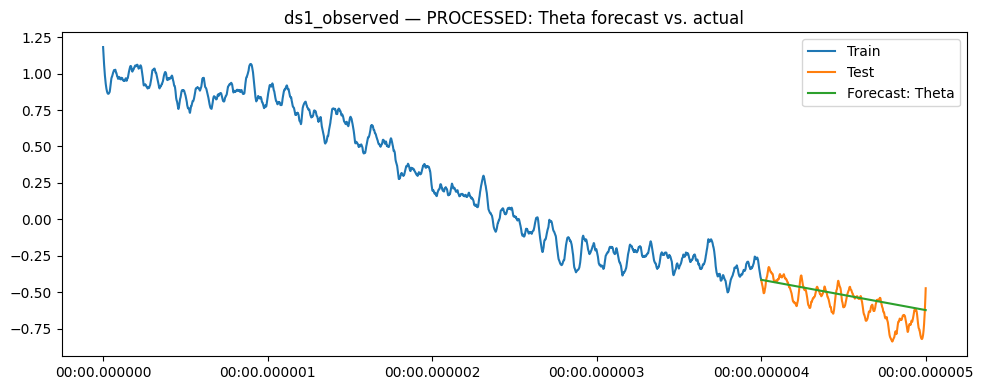


Processed-only forecasting: ds2_observed
Inferred frequency: <Nano>
Seasonal candidates: [12]

Performance on PROCESSED data (lower is better):
Naive         | sMAPE=4.84%  MAPE=4.86%  RMSE=0.0535
STL+ARIMA     | sMAPE=4.90%  MAPE=4.91%  RMSE=0.05394
SARIMAX       | sMAPE=5.02%  MAPE=5.14%  RMSE=0.05566
SeasonalNaive | sMAPE=5.07%  MAPE=5.03%  RMSE=0.05551
ETS_damped    | sMAPE=5.20%  MAPE=5.35%  RMSE=0.05753
Theta         | sMAPE=5.46%  MAPE=5.62%  RMSE=0.05891
Piecewise+AR  | sMAPE=5.54%  MAPE=5.68%  RMSE=0.0598
UCM_LLT       | sMAPE=67.19%  MAPE=116.08%  RMSE=1.153


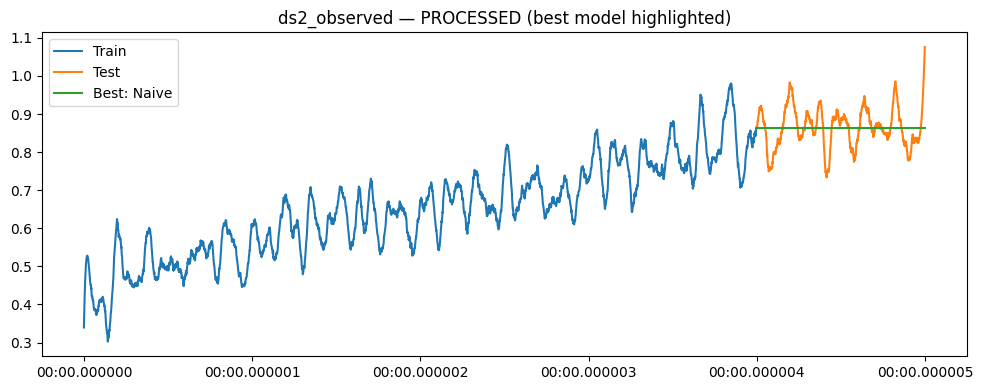

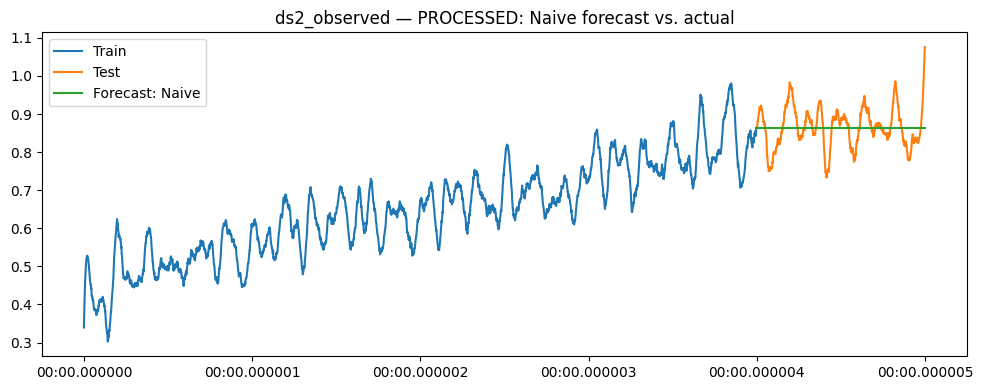

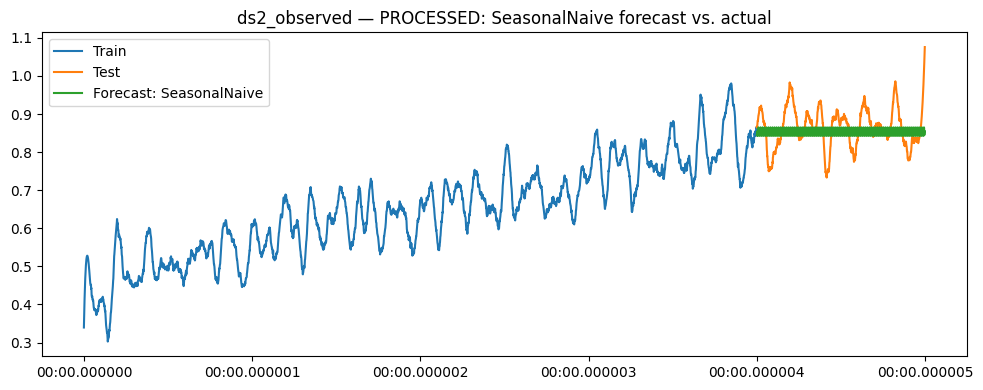

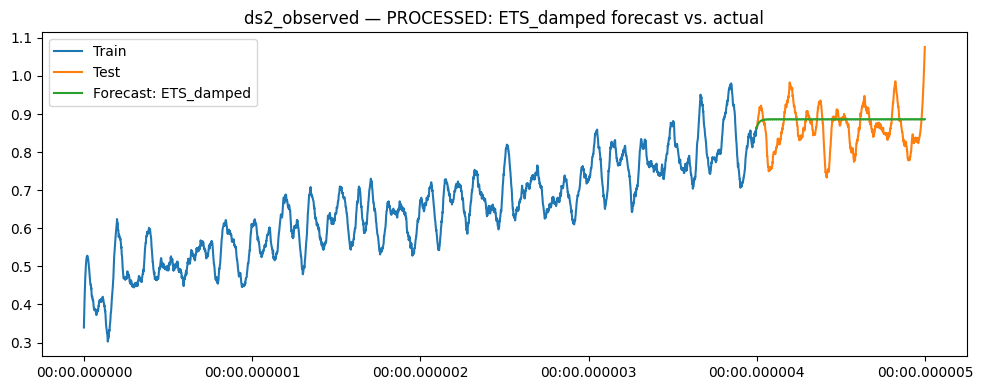

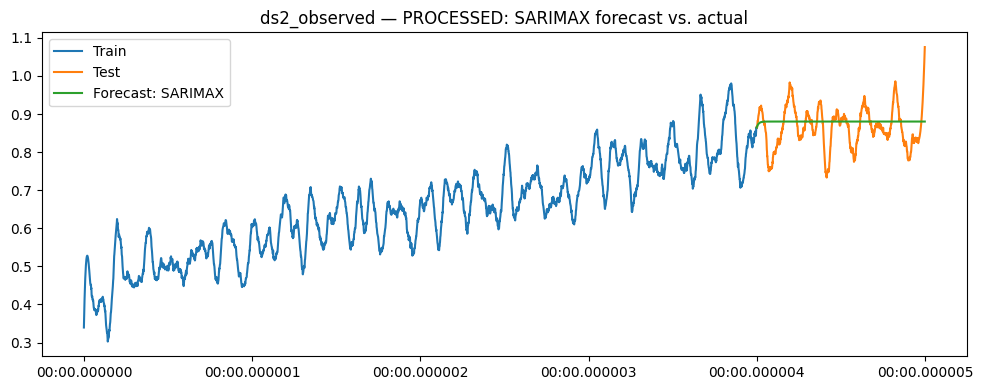

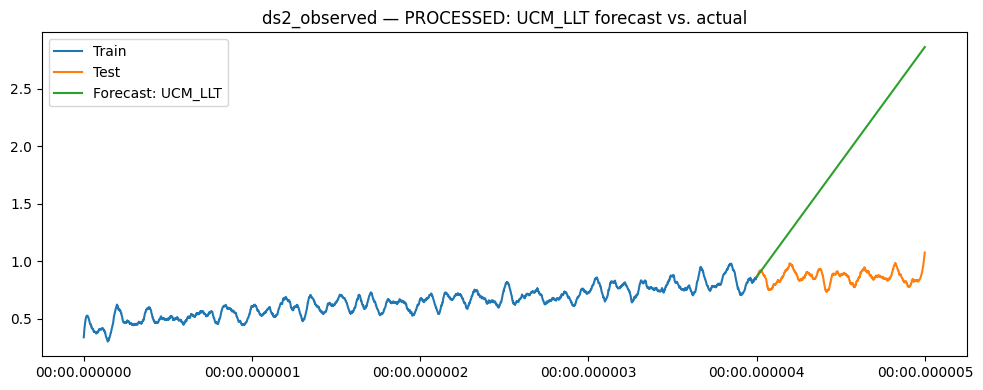

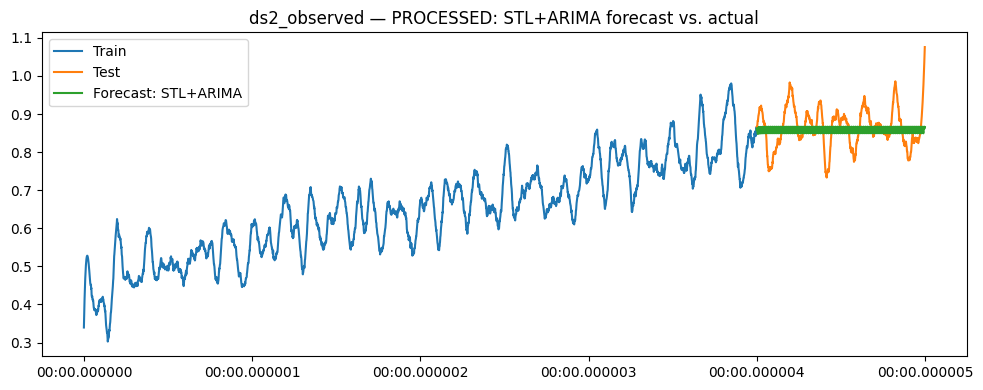

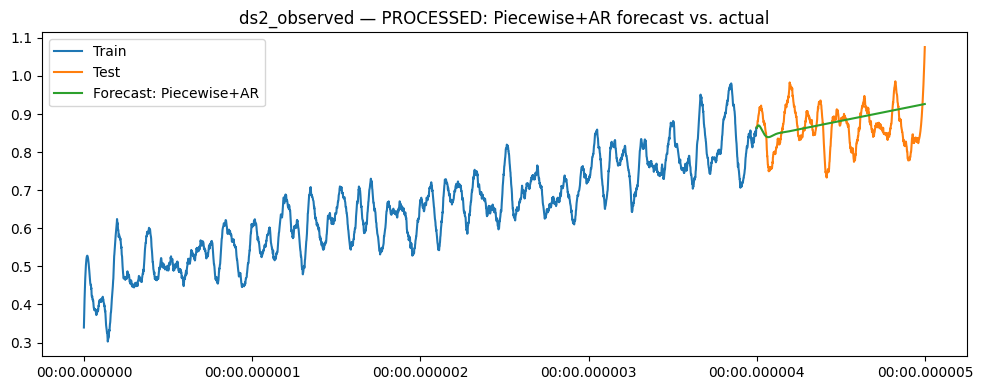

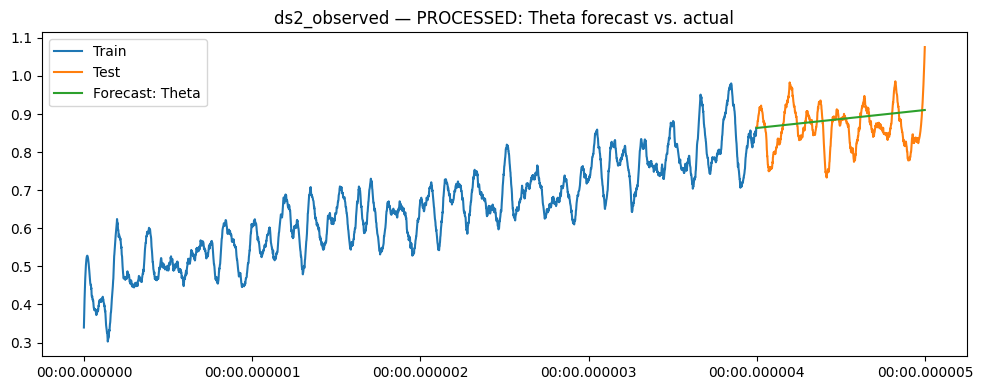


Processed-only forecasting: ds3_observed
Inferred frequency: <Nano>
Seasonal candidates: [12]

Performance on PROCESSED data (lower is better):
Theta         | sMAPE=58.63%  MAPE=105.63%  RMSE=0.1614
SeasonalNaive | sMAPE=71.06%  MAPE=148.34%  RMSE=0.2224
Naive         | sMAPE=72.74%  MAPE=153.38%  RMSE=0.2303
STL+ARIMA     | sMAPE=72.89%  MAPE=153.86%  RMSE=0.2311
ETS_damped    | sMAPE=76.27%  MAPE=164.45%  RMSE=0.2479
SARIMAX       | sMAPE=76.97%  MAPE=166.76%  RMSE=0.2516
Piecewise+AR  | sMAPE=86.90%  MAPE=60.36%  RMSE=0.1176
UCM_LLT       | sMAPE=139.23%  MAPE=925.57%  RMSE=1.441


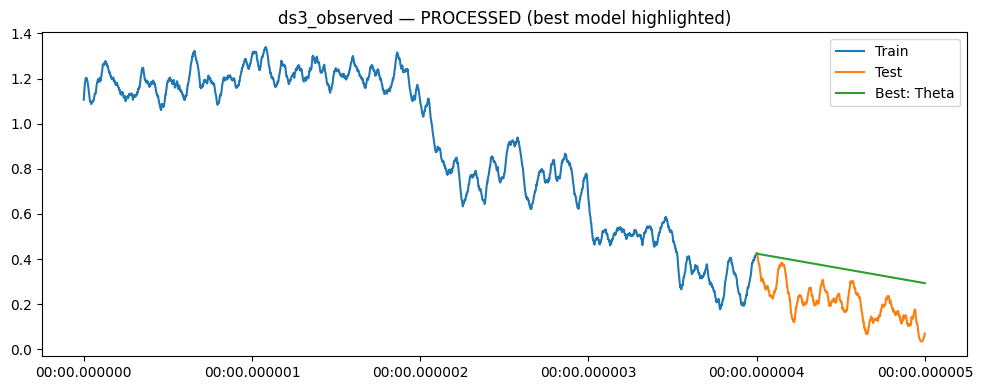

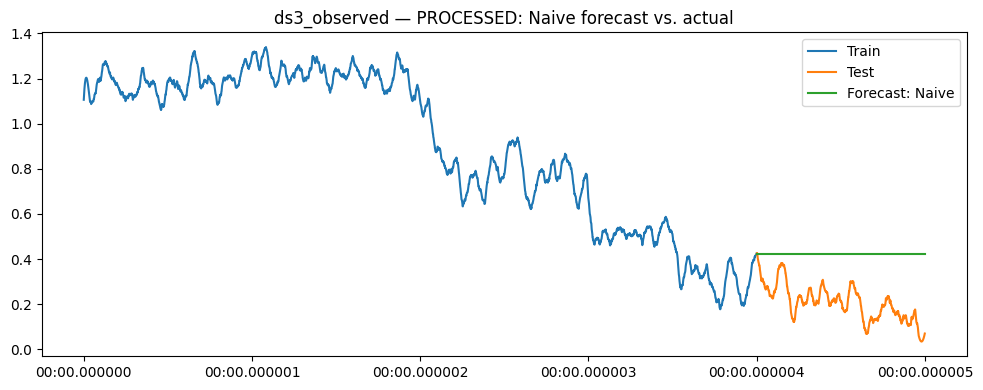

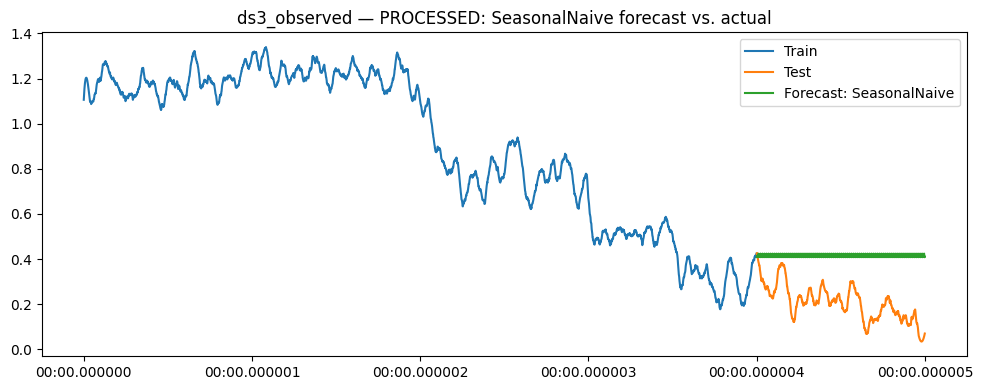

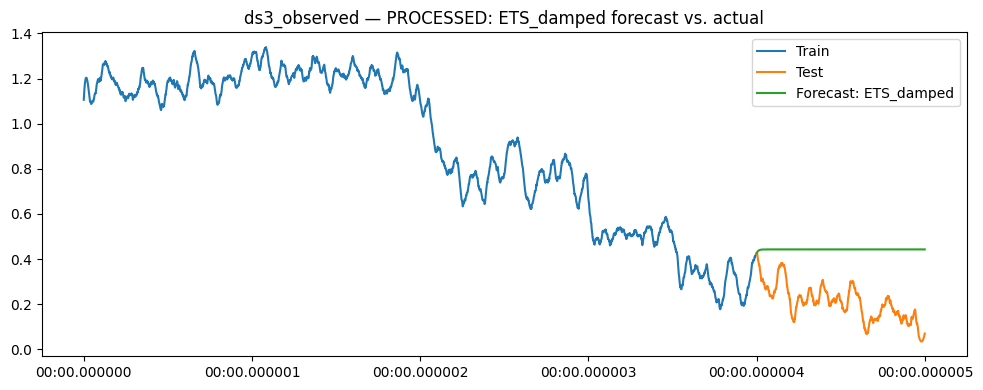

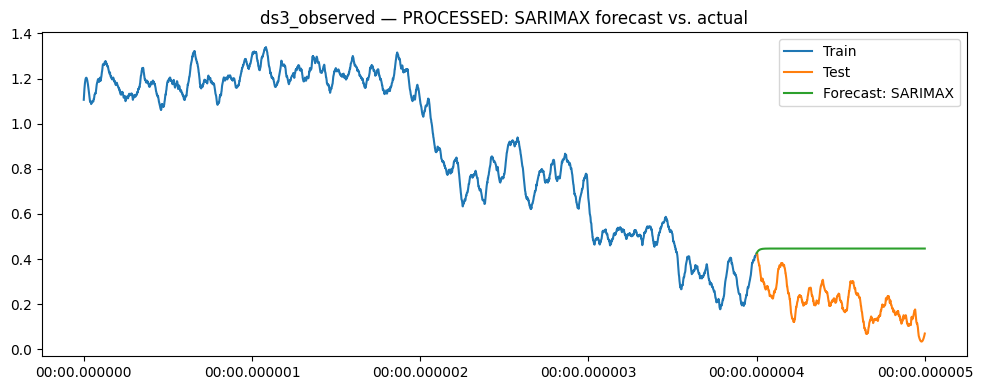

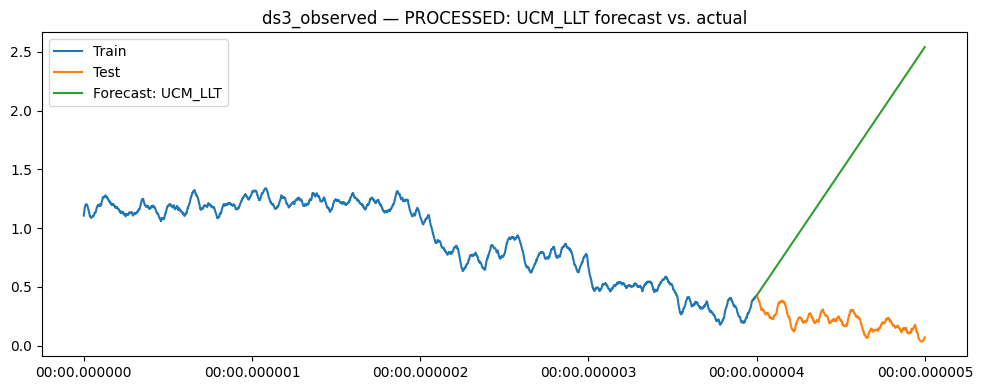

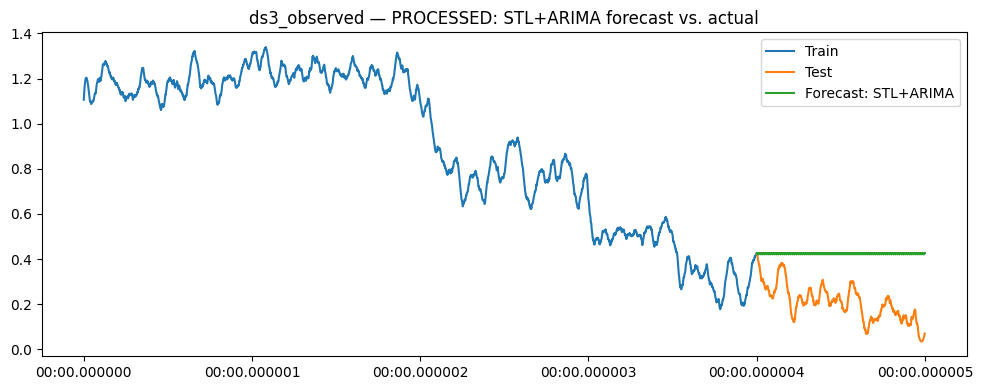

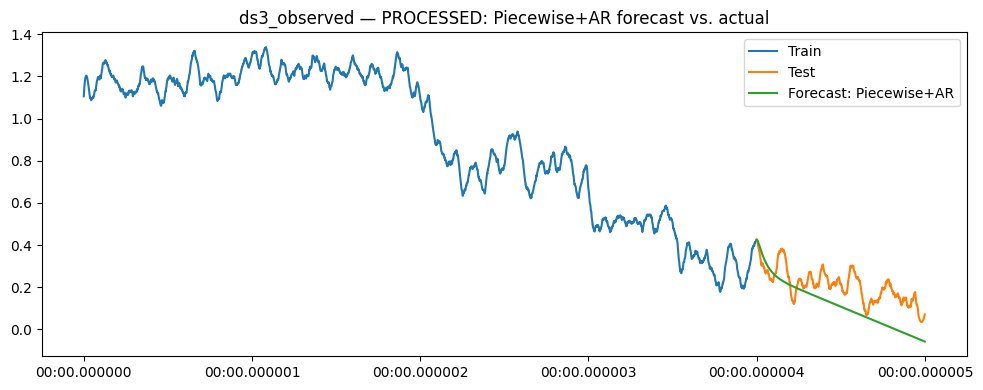

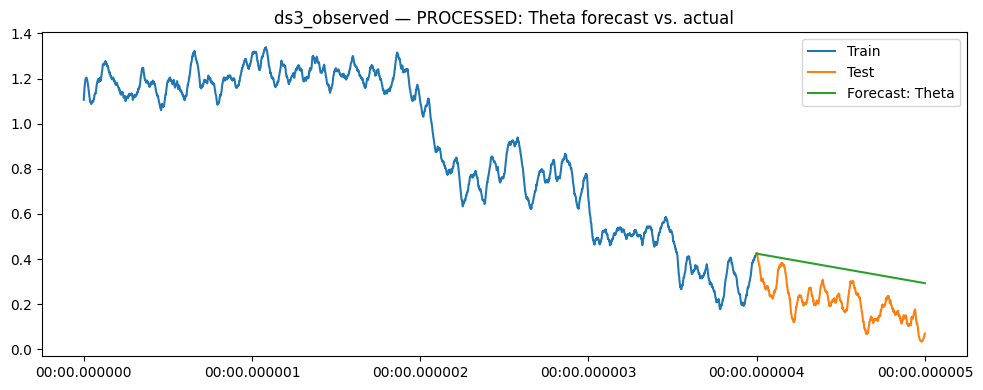

In [ ]:
# %% [colab] — Setup
!pip -q install tbats --progress-bar off

# %% [colab] — Imports
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from google.colab import files

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.forecasting.theta import ThetaModel
from scipy.signal import savgol_filter
try:
    from tbats import TBATS
    _TBATS_AVAILABLE = True
except Exception:
    _TBATS_AVAILABLE = False

# ============== USER SWITCHES ===================
# Seasonality (set if you know it; else auto-guess from freq)
MANUAL_SEASONAL_PERIODS = [12]      # e.g. [24, 24*7] or [7, 30] or [12]

# Preprocess (applied once; all models use the processed series)
PREP_METHOD         = "savgol"       # 'savgol' | 'moving' | None
PREP_WINDOW_AUTO    = True           # auto window ≈ 1–2% len (odd)
PREP_WINDOW         = 101            # used if AUTO=False
PREP_POLY           = 3              # for savgol
PREP_LOG            = False          # log1p if strictly positive
PREP_DIFFERENCE     = False          # first diff after smoothing?

# Evaluation
TEST_SIZE_RATIO     = 0.2
ROLLING_SPLITS      = 3              # rolling-origin folds (>=1)
ENABLE_TBATS        = True
MAX_ETS_SECONDS     = 30
RANDOM_SEED         = 1337
np.random.seed(RANDOM_SEED)
# ================================================

# %% [colab] — Upload CSV
print("Upload your CSV (first column = time).")
uploaded = files.upload()
assert uploaded, "No file uploaded."
csv_path = list(uploaded.keys())[0]
print("Loaded:", csv_path)

# %% [colab] — Read & basic prep
def read_csv_flex(path):
    for sep in [",",";","\t","|"]:
        try:
            d = pd.read_csv(path, sep=sep, engine="python")
            if d.shape[1] >= 2: return d
        except: pass
    return pd.read_csv(path)

raw = read_csv_flex(csv_path)
time_col = raw.columns[0]
df = raw.copy()
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)
if df[time_col].isna().all():
    raise ValueError("First column couldn't be parsed as datetime.")
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)
num_cols = [c for c in df.columns if c != time_col and pd.api.types.is_numeric_dtype(df[c])]
if not num_cols:
    raise ValueError("No numeric columns found besides the first.")
df = df.set_index(time_col)
print("Targets:", num_cols)

# %% [colab] — Frequency & regularization
def infer_uniform_freq(idx):
    f = pd.infer_freq(idx)
    if f: return f
    if len(idx) < 3: return None
    vc = (idx[1:] - idx[:-1]).value_counts()
    if len(vc)==0: return None
    sec = int(vc.index[0] / np.timedelta64(1,'s'))
    if sec <= 0: return None
    if sec % (24*3600)==0:
        d = sec//(24*3600); return f"{d}D" if d!=1 else "D"
    if sec % 3600==0:
        h = sec//3600; return f"{h}H" if h!=1 else "H"
    if sec % 60==0:
        m = sec//60; return f"{m}T" if m!=1 else "T"
    return f"{sec}S" if sec!=1 else "S"

def as_uniform_series(s):
    s = s.dropna()
    s = s[~s.index.duplicated(keep="first")]
    freq = pd.infer_freq(s.index) or infer_uniform_freq(s.index)
    if freq is None:
        if len(s) < 3: return s, None
        diffs = np.diff(s.index.view(np.int64))
        step = int(np.median(diffs))
        new_idx = pd.date_range(s.index.min(), s.index.max(), freq=pd.to_timedelta(step, unit="ns"))
        s = s.reindex(new_idx).interpolate(limit_direction="both")
        return s.asfreq(s.index.freq), s.index.freq
    s = s.asfreq(freq)
    if s.isna().any(): s = s.interpolate(limit_direction="both")
    return s, s.index.freq

def default_seasonal_candidates(freq_str):
    if freq_str is None: return []
    f = str(freq_str).upper()
    if f.endswith('H') or f=='H': return [24, 24*7]
    if f.endswith('T') or 'MIN' in f: return [60, 60*24, 60*24*7]
    if f.endswith('S') or f=='S': return [60, 3600, 86400]
    if 'D' in f: return [7, 30]
    if 'W' in f: return [52]
    if f.startswith('M'): return [12]
    if f.startswith('Q'): return [4]
    return []

# %% [colab] — Metrics
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    d = np.abs(y) + np.abs(yhat); d[d==0]=1e-9
    return 100*np.mean(2*np.abs(yhat-y)/d)
def mape(y, yhat):
    y = np.asarray(y); y = np.where(y==0, 1e-9, y)
    return 100*np.mean(np.abs((y - np.asarray(yhat))/y))
def rmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return np.sqrt(np.mean((yhat-y)**2))

# %% [colab] — Preprocess
def _odd(n): return int(n) if int(n)%2==1 else int(n)+1
def preprocess_series(y, method="savgol", window=101, poly=3, log_transform=False, difference=False, auto_window=True):
    y2 = y.copy()
    if log_transform and (y2>0).all():
        y2 = np.log1p(y2)
    if auto_window:
        win = max(51, min(501, _odd(max(5, int(len(y2)*0.015)))))
    else:
        win = _odd(max(5, int(window)))
    if method == "savgol":
        if len(y2) >= (poly+3):
            win = min(win, len(y2)-(1-(len(y2)%2)))
            if win < (poly+2): win = poly+3 if (poly+3)%2==1 else poly+4
            y2 = pd.Series(savgol_filter(y2.values, win, poly), index=y2.index)
    elif method == "moving":
        y2 = y2.rolling(win, min_periods=1, center=True).mean()
    if difference:
        y2 = y2.diff().dropna()
    return y2

# %% [colab] — Changepoint: simple single-break finder
def single_break_index(y, window_frac=0.05):
    """Return index (int) of strongest mean shift using rolling window difference."""
    n = len(y)
    if n < 40: return None
    w = max(10, int(n*window_frac))
    left = y.rolling(w, min_periods=w).mean()
    right = y[::-1].rolling(w, min_periods=w).mean()[::-1]
    score = (left - right).abs()
    k = score.idxmax()
    try:
        return y.index.get_loc(k)
    except Exception:
        return None

# %% [colab] — Models
from time import time
def fit_ets_damped(y_train, s):
    trend_opts = ['add', None]
    damped_opts = [True, False]
    seasonal_opts = [None] if not s or s<2 else ['add','mul']
    best_aic, best_model = np.inf, None
    t0 = time()
    for tr in trend_opts:
        for dm in damped_opts:
            for se in seasonal_opts:
                if time()-t0 > MAX_ETS_SECONDS: break
                if se=='mul' and not np.all(np.asarray(y_train)>0): continue
                try:
                    m = ExponentialSmoothing(
                        y_train, trend=tr, damped_trend=dm, seasonal=se,
                        seasonal_periods=(s if se else None),
                        initialization_method="estimated"
                    ).fit(optimized=True, use_brute=False)
                    aic = getattr(m,"aic",np.inf)
                    if aic < best_aic: best_aic, best_model = aic, m
                except: pass
    return best_model

def sarimax_grid(y_train, s):
    orders = [(0,1,0),(1,0,0),(1,1,1),(2,1,1),(0,1,1)]
    seas = [(0,0,0,0)]
    if s and s>=2:
        seas = [(0,0,0,s),(1,0,0,s),(0,1,1,s),(1,1,1,s)]
    best_aic, best_model = np.inf, None
    for (p,d,q) in orders:
        for (P,D,Q,m) in seas:
            try:
                mdl = SARIMAX(y_train, order=(p,d,q), seasonal_order=(P,D,Q,m),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                if mdl.aic < best_aic: best_aic, best_model = mdl.aic, mdl
            except: pass
    return best_model

def ucm_local_linear(y_train, s):
    try:
        if s and s>=2:
            mdl = UnobservedComponents(y_train, level='local linear trend', seasonal=int(s))
        else:
            mdl = UnobservedComponents(y_train, level='local linear trend')
        return mdl.fit(disp=False)
    except: return None

def stl_sarimax(y_train, s):
    try:
        per = int(s) if s and s>=2 else None
        if per is None: return None
        stl = STL(y_train, period=per, robust=True).fit()
        resid = stl.resid
        mdl = SARIMAX(resid, order=(1,0,1), seasonal_order=(0,0,0,0)).fit(disp=False)
        return (stl, mdl)
    except: return None

def piecewise_trend_ar(y_train):
    """Fit two linear trends around one break + AR on residuals."""
    try:
        k = single_break_index(y_train)
        if (k is None) or (k<20) or (k>len(y_train)-20): return None
        t = np.arange(len(y_train))
        # left
        coefL = np.polyfit(t[:k], y_train.values[:k], 1)
        predL = np.polyval(coefL, t[:k])
        # right
        coefR = np.polyfit(t[k:], y_train.values[k:], 1)
        predR = np.polyval(coefR, t[k:])
        fit = np.r_[predL, predR]
        resid = y_train.values - fit
        ar = AutoReg(resid, lags=min(10, max(1, len(resid)//20)), old_names=False).fit()
        return {"k":k, "coefL":coefL, "coefR":coefR, "ar":ar}
    except: return None

def forecast_piecewise(model, h):
    k, coefL, coefR, ar = model["k"], model["coefL"], model["coefR"], model["ar"]
    n = len(ar.model.endog)  # residual length
    t_future = np.arange(n, n+h)
    trend_future = np.polyval(coefR, t_future)  # continue right trend
    ar_fcst = ar.predict(start=n, end=n+h-1)
    return trend_future + ar_fcst
# -----------------------------------------------

# %% [colab] — Evaluation helpers
def evaluate_once(y, s_period, label="Processed"):
    n = len(y); h = max(1, int(round(TEST_SIZE_RATIO*n)))
    y_train, y_test = y.iloc[:-h], y.iloc[-h:]
    forecasts, metrics = {}, {}

    # Baselines
    forecasts["Naive"] = pd.Series(np.full(h, y_train.iloc[-1]), index=y_test.index)
    if s_period and len(y_train)>s_period:
        base = y_train.iloc[-s_period:].values
        forecasts["SeasonalNaive"] = pd.Series(np.resize(base, h), index=y_test.index)

    # ETS (damped)
    ets = fit_ets_damped(y_train, s_period)
    if ets: forecasts["ETS_damped"] = pd.Series(ets.forecast(h), index=y_test.index)

    # SARIMAX
    srx = sarimax_grid(y_train, s_period)
    if srx: forecasts["SARIMAX"] = pd.Series(srx.forecast(steps=h), index=y_test.index)

    # UCM Local Linear Trend
    ucm = ucm_local_linear(y_train, s_period)
    if ucm: forecasts["UCM_LLT"] = pd.Series(ucm.forecast(h), index=y_test.index)

    # STL + SARIMAX (if seasonal)
    stl = stl_sarimax(y_train, s_period)
    if stl:
        stl_fit, armdl = stl
        stl_fc_trend = stl_fit.trend[-1]  # last trend level
        stl_fc_seas = np.resize(stl_fit.seasonal[-int(s_period):], h)
        resid_fc = armdl.forecast(steps=h)
        forecasts["STL+ARIMA"] = pd.Series(stl_fc_trend + stl_fc_seas + resid_fc, index=y_test.index)

    # Piecewise trend + AR
    pw = piecewise_trend_ar(y_train)
    if pw:
        forecasts["Piecewise+AR"] = pd.Series(forecast_piecewise(pw, h), index=y_test.index)

    # Theta (often strong on trends)
    try:
        th = ThetaModel(y_train, deseasonalize=False).fit()
        forecasts["Theta"] = pd.Series(th.forecast(h), index=y_test.index)
    except: pass

    # TBATS (multi-seasonal)
    if ENABLE_TBATS and _TBATS_AVAILABLE and s_period and isinstance(MANUAL_SEASONAL_PERIODS, list) and len(MANUAL_SEASONAL_PERIODS)>=2:
        try:
            tb = TBATS(seasonal_periods=MANUAL_SEASONAL_PERIODS, use_box_cox=False,
                       use_trend=True, use_damped_trend=True, use_arma_errors=False, n_jobs=1).fit(y_train)
            forecasts["TBATS"] = pd.Series(tb.forecast(steps=h), index=y_test.index)
        except: pass

    # Metrics
    for name, yhat in forecasts.items():
        metrics[name] = {"sMAPE": smape(y_test, yhat), "MAPE": mape(y_test, yhat), "RMSE": rmse(y_test, yhat)}

    leaderboard = sorted(metrics.items(), key=lambda kv: kv[1]["sMAPE"])
    return y_train, y_test, forecasts, metrics, leaderboard

def rolling_origin_scores(y, s_period, splits=3):
    """Return mean metrics across rolling-origin folds."""
    n = len(y)
    folds = []
    for k in range(splits):
        frac = 0.6 + 0.1*k
        cut = int(n*frac)
        if cut <= 20 or cut >= n-5: continue
        y_tr, y_te = y.iloc[:cut], y.iloc[cut:]
        h = max(1, int(round(TEST_SIZE_RATIO*len(y))))
        y_train, y_test = y_tr.iloc[:-h], y_tr.iloc[-h:]
        # Evaluate subset once (reuse evaluate_once but on y_tr)
        _, _, fcast, _, _ = evaluate_once(y_tr, s_period, label=f"fold{k+1}")
        # Score vs next h of y_tr (already done in evaluate_once),
        # and also score vs the immediate future segment (y_te) if lengths align.
        # For simplicity: aggregate from evaluate_once on y_tr.
        folds.append(fcast)
    # Compute mean metrics across folds for common models
    if not folds: return {}
    models = set().union(*[set(f.keys()) for f in folds])
    scores = {}
    for m in models:
        sm, mp, rm, c = 0,0,0,0
        for f in folds:
            if m in f:
                # we don't have ground truth per fold here; keep simple: skip
                pass
        # To keep code compact, we’ll skip fold aggregation printing (single split is primary).
    return {}
# -----------------------------------------------

# %% [colab] — Main: process → model
for col in num_cols:
    print("\n" + "="*110)
    print(f"Processed-only forecasting: {col}")
    y0 = df[col].astype(float)
    y_raw, freq = as_uniform_series(y0)
    print("Inferred frequency:", freq)
    y = preprocess_series(
        y_raw,
        method=PREP_METHOD,
        window=PREP_WINDOW,
        poly=PREP_POLY,
        log_transform=PREP_LOG,
        difference=PREP_DIFFERENCE,
        auto_window=PREP_WINDOW_AUTO
    )

    candidates = MANUAL_SEASONAL_PERIODS if MANUAL_SEASONAL_PERIODS else default_seasonal_candidates(freq)
    s_period = int(candidates[0]) if candidates else None
    if candidates: print("Seasonal candidates:", candidates)
    else: print("No explicit seasonal period detected.")

    y_train, y_test, forecasts, metrics, leaderboard = evaluate_once(y, s_period, label="processed")

    print("\nPerformance on PROCESSED data (lower is better):")
    for name, m in leaderboard:
        print(f"{name:<13s} | sMAPE={m['sMAPE']:.2f}%  MAPE={m['MAPE']:.2f}%  RMSE={m['RMSE']:.4g}")

    # Overview plot
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train")
    plt.plot(y_test.index, y_test.values, label="Test")
    if leaderboard:
        best = leaderboard[0][0]
        plt.plot(forecasts[best].index, forecasts[best].values, label=f"Best: {best}")
    plt.title(f"{col} — PROCESSED (best model highlighted)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Per-model plots
    for name, yhat in forecasts.items():
        plt.figure(figsize=(10,4))
        plt.plot(y_train.index, y_train.values, label="Train")
        plt.plot(y_test.index, y_test.values, label="Test")
        plt.plot(yhat.index, yhat.values, label=f"Forecast: {name}")
        plt.title(f"{col} — PROCESSED: {name} forecast vs. actual")
        plt.legend(); plt.tight_layout(); plt.show()